# 1) Introduction: The Crime Analysis task ..._Markdown_, **10 Marks**, Max 300 Words



### Background
Crime Analysis is an important part of criminology and public policy especially in the segment of violent crime. For getting better understanding of crime trends and for evaluating crime prevention strategies through analysis of crime data is required. In recent study and researches of crime patterns, the impact of external factors like socioeconomic changes or public health crises like the COVID-19 pandemic is acquiring huge attraction(The Economist 2020; Piquero et al. 2021).

### Aims and Objectives


The main aim of the project is to check whether the crime rate increased or decreased during the COVID-19 pandemic lockdown in the UK. So, we will be analyzing the official crime data provided by the UK Police and mainly the on the violent crimes. The specific objectives are:

* Finding out whether the violent crimes are increasing or decreasing or is stable.
* Using the pre-lockdown data we need to predict the violent crime levels for the month of April 2020.
* Checking for significant changes in predicted vs actual violent crime data.
* Checking only for leicester region for any significant change in predicted crime vs actual crime for July 2020.
### Technical Approach
The technical approach involves processing the provided data efficiently using Apache Spark on a cloud Infrastructure as a Service (IaaS) platform. The analysis will:

* Filter the dataset for violent crimes.
* Use statistical techniques to determine trends in violent crimes.
* Employ machine learning models to predict future crime levels.
* Utilize visualizations to support analytic findings and interpretations.


# 2) Component Selection and Data Pipeline Implementation _code_	**10 Marks**

In [5]:
# Standard libraries
import copy
import itertools
import warnings

# Data manipulation and analysis libraries
import pandas as pd
import numpy as np
from math import sqrt

# Statistical modeling libraries
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import DataFrame


# Miscellaneous configurations
warnings.filterwarnings('ignore')

global uk_crime_count_pd_df
global lstr_crime_count_pd_df

In [6]:
# Spark session operations

# Creating a Spark session
# This initializes a Spark session for your application named "uk_crime_analysis".
# The builder method is used to configure the session.
spark = SparkSession.builder.appName("uk_crime_analysis").getOrCreate()

# Getting the SparkContext from the Spark session
# SparkContext is the entry point for low-level Spark functionalities like RDDs.
sc = spark.sparkContext

# Setting the log level to "ERROR" to reduce the amount of log output
# This is useful to see only error messages in the output, making debugging easier.
sc.setLogLevel("ERROR")

24/02/13 13:15:36 WARN Utils: Your hostname, Arkas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.26.22.100 instead (on interface en0)
24/02/13 13:15:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/13 13:15:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Reading the CSV file into a DataFrame
# Specify the 'header' parameter as True to use the first line of the file as column names
uk_crime_spark_df = spark.read.csv("data/all_crimes21_hdr.csv", header=True)

# Display the first few rows of the DataFrame to verify successful loading
uk_crime_spark_df.show()

# 3) Data Extraction and Filtering ... _code_, 10 Marks

In [4]:
# Data Extraction
# Selecting specific columns: 'Month', 'LSOA name' (location), and 'Crime type'
selected_columns = ["Month", "LSOA name", "Crime type"]
uk_crime_spark_selected_df = uk_crime_spark_df.select(selected_columns)
uk_crime_spark_selected_df.show()

+-------+--------------------+--------------------+
|  Month|           LSOA name|          Crime type|
+-------+--------------------+--------------------+
|2010-12| Aylesbury Vale 015C|         Other crime|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|            Burglary|
|2010-12|Bath and North Ea...|            Burglary|
|2010-12|Bath and North Ea...|         Other crime|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|Anti-social behav...|
|2010-12|Bath and North Ea...|            Burglary|
|2010-12|Bat

In [5]:
def filter_and_process_crime_data(df: DataFrame, show_n_rows: int = 5, region: str = 10):
    """
    Filter and process crime data.

    Args:
    df (DataFrame): Spark DataFrame containing UK or Leicester crime data.
    show_n_rows (int): Number of rows to display after each processing step.

    Returns:
    pandas.DataFrame: Processed DataFrame.
    """
    if region == "uk":
        # Filter for violent and sexual crimes
        violent_sexual_condition = (df["Crime type"].startswith("Violent") |
                                    df["Crime type"].startswith("Violence and sexual"))
    elif region == "Leicester":
        violent_sexual_condition = (
                ((col("Crime type").startswith("Violent")) | (col("Crime type").startswith("Violence and sexual")))  & (col("LSOA name").startswith("Leicester")))
        
    filtered_df = df.filter(violent_sexual_condition)

    # Show the first few rows of the filtered DataFrame
    print(f"Filtered DataFrame: {region}")
    filtered_df.show(n=show_n_rows)

    # Group by month and count crimes
    crime_count_df = filtered_df.groupBy("Month").count()

    # Convert to pandas DataFrame
    crime_count_pd_df = crime_count_df.toPandas()

    # Sort and process the DataFrame
    crime_count_pd_df = crime_count_pd_df.sort_values(by='Month')
    crime_count_pd_df.Month = crime_count_pd_df.Month.astype('datetime64[ns]')
    crime_count_pd_df = crime_count_pd_df.set_index(pd.to_datetime(crime_count_pd_df.Month))
    print(f"below is the panda df for {region} region")
    crime_count_pd_df.head(5)
    return crime_count_pd_df
region = "uk"

In [6]:
uk_crime_count_pd_df = filter_and_process_crime_data(uk_crime_spark_selected_df, 5, region)
uk_crime_count_pd_df.head()

Filtered DataFrame: uk
+-------+--------------------+-------------+
|  Month|           LSOA name|   Crime type|
+-------+--------------------+-------------+
|2010-12|Bath and North Ea...|Violent crime|
|2010-12|Bath and North Ea...|Violent crime|
|2010-12|Bath and North Ea...|Violent crime|
|2010-12|Bath and North Ea...|Violent crime|
|2010-12|Bath and North Ea...|Violent crime|
+-------+--------------------+-------------+
only showing top 5 rows


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=25358Kb max_used=25370Kb free=105713Kb
 bounds [0x0000000106350000, 0x0000000107c50000, 0x000000010e350000]
 total_blobs=10141 nmethods=9216 adapters=837
 compilation: disabled (not enough contiguous free space left)
below is the panda df for uk region


,Month,count
Month,,
2010-12-01,2010-12-01,57580
2011-01-01,2011-01-01,59823
2011-02-01,2011-02-01,56691
2011-03-01,2011-03-01,62326
2011-04-01,2011-04-01,64299


#### For statistical analysis, we can perform a time series decomposition to understand the trend, seasonality, and noise in the data. ####

In [7]:
def analyze_and_plot_trend(df: pd.DataFrame, column: str, region: str,  window_size: int = 50 ):
    """
    Analyze and plot the trend in a time series DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the time series data.
    column (str): The name of the column to analyze.
    window_size (int): The window size for rolling average calculation.
    """
    
    print(f"Time series decomposition plot and Time Series Plot of Crime Data with Rolling Average for {region}")
    # Time Series Decomposition
    ts_decomposition = sm.tsa.seasonal_decompose(df[column], model='additive', extrapolate_trend='freq')
    # plt.title('Time Series Decomposition plot of crime count')
    # Plotting the Decomposition
    fig = ts_decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()

    # Trend Analysis
    trend_df = df.copy()
    trend_df['Percent_Change'] = trend_df[column].pct_change() * 100
    trend_df['Rolling_Average'] = trend_df[column].rolling(window=window_size, min_periods=1).mean()

    # Determining Overall Trend
    overall_trend = 'Stable'
    if trend_df['Percent_Change'].mean() > 0:
        overall_trend = 'Increasing'
    elif trend_df['Percent_Change'].mean() < 0:
        overall_trend = 'Decreasing'
    print(f"Overall trend in crime: {overall_trend}")

    # Plotting Time Series with Rolling Average
    plt.figure(figsize=(12, 6))
    plt.plot(trend_df.index, trend_df['Rolling_Average'], marker='o', label='Smoothed Curve')
    plt.plot(trend_df.index, trend_df[column], linestyle='--', label='Original Data', alpha=0.5)
    plt.xlabel('Month')
    plt.ylabel('Count of Crime')
    plt.title(f'Time Series Plot of Crime Data with Rolling Average for {region}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Time series decomposition plot and Time Series Plot of Crime Data with Rolling Average for UK


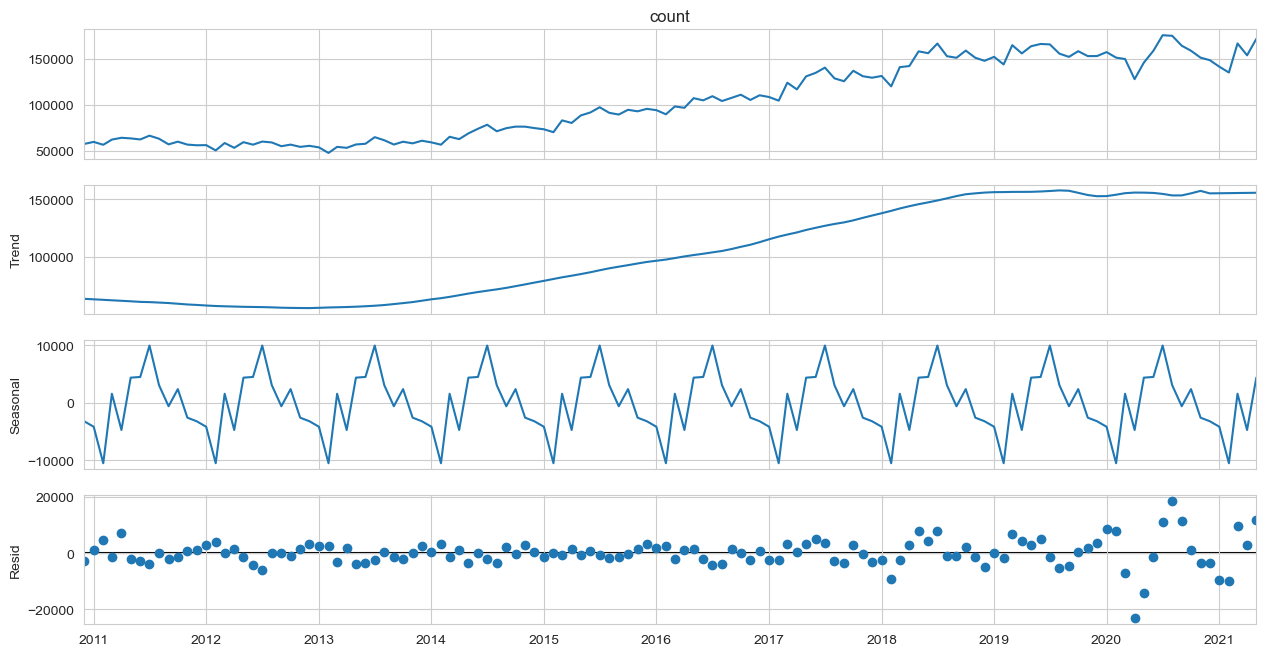

Overall trend in crime: Increasing


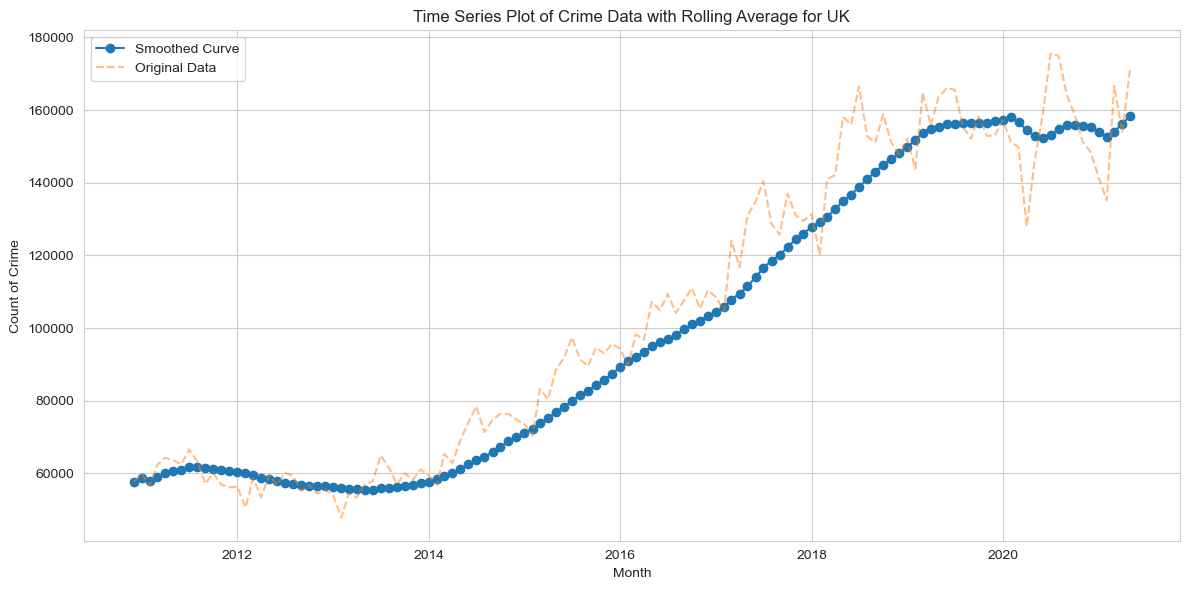

In [8]:
# Function call for Time series decomposition plot and Time Series Plot of Crime Data with Rolling Average
analyze_and_plot_trend(uk_crime_count_pd_df, 'count', 'UK', window_size=12)

The first graph is a time series decomposition plot and this type of plot typically breaks down a time series dataset into three components:

1. **Trend**: This trend basically tells us the long-term progression series and in our graph there is a upward trend which suggests that the crime count is increasing over time.

2. **Seasonal**: This part of the graph tells the fluctuations in the seasonality (at monthly intervals in our case). By looking at our graph we can tell that there is repeating pattern, that means, there is seasonal influence on the data.

3. **Residual**: These are the irregularities or random variations that remain after the trend and seasonal components are removed from the time series. Ideally, these should be random and small.So, in our graph we can see that the residuals are fairly small and is scattered around zero which indicates the model has captured most of the systematic information in the data.

From the above graphs we can tell that the crime is increasing over time. As per the percentage calculation, the trend of the crime is increasing.

## Data extracting , filtering and checking trend for leicester region

In [9]:
region = "Leicester"
lstr_crime_count_pd_df = filter_and_process_crime_data(uk_crime_spark_selected_df, 5, region)

Filtered DataFrame: Leicester
+-------+--------------+-------------+
|  Month|     LSOA name|   Crime type|
+-------+--------------+-------------+
|2010-12|Leicester 001A|Violent crime|
|2010-12|Leicester 001B|Violent crime|
|2010-12|Leicester 001B|Violent crime|
|2010-12|Leicester 001C|Violent crime|
|2010-12|Leicester 001C|Violent crime|
+-------+--------------+-------------+
only showing top 5 rows


below is the panda df for Leicester region


Time series decomposition plot and Time Series Plot of Crime Data with Rolling Average for Leicester


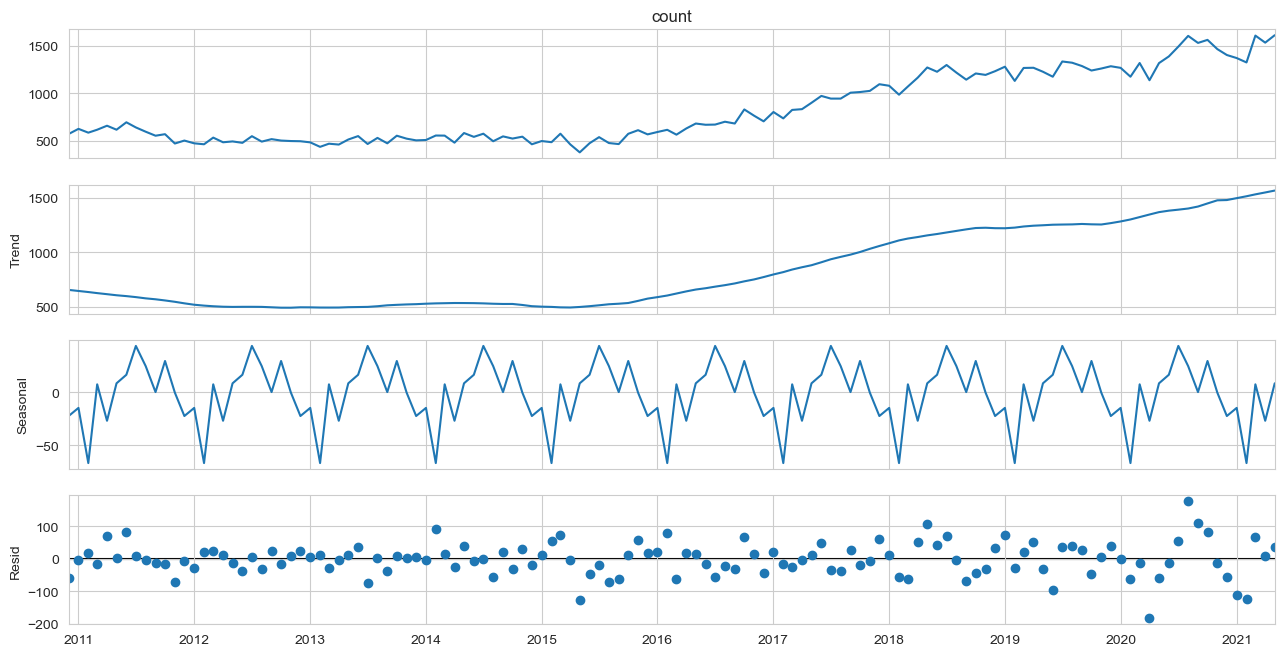

Overall trend in crime: Increasing


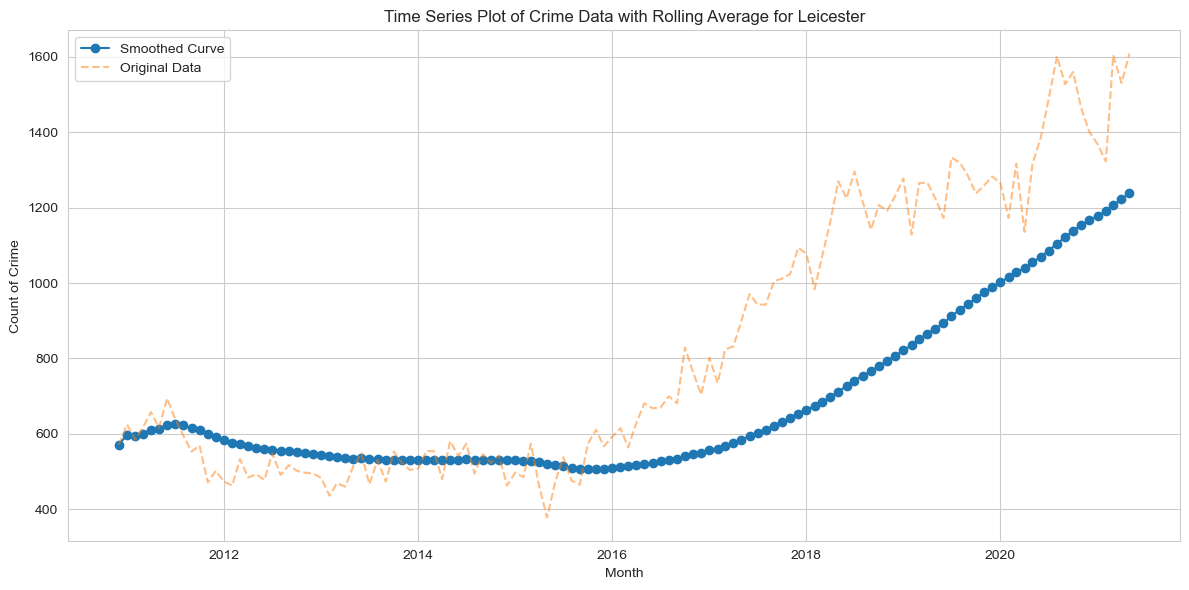

In [10]:
analyze_and_plot_trend(lstr_crime_count_pd_df, 'count', 'Leicester', window_size=50)

From the above graphs we can tell that the crime is increasing over time for the leicester region. As per the percentage calculation, the trend of the crime is increasing.So both the above graphs suggest that crime count is subjected to both seasonal variation and a long-term increasing trend. The main difference with the UK graphs is that there is uptick before 2016 and for Leicester crime seems to be increasing after 2016


# 4) Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models,  _markdown_, _code_,  _markdown_, 20 Marks

#### Visualization for the UK region ####
Our working dataset contains two columns "Month" and "count". "Month" represents the month and year and "count" indicates the number of crimes recorded in that month. Based on this I have provided four different visualization methods to analyze the data. Each visualization will aim to show different aspects and trends in the crime data.

In [11]:
def plot_crime_data(df: pd.DataFrame, visualization_type: str, region: str):
    """
    Plot different types of visualizations for crime data based on the specified region.

    Args:
    df (pd.DataFrame): The DataFrame containing the crime data.
    visualization_type (str): Type of visualization ('Time Series Line Chart', 'Histogram', 'Box Plot', 'Heatmap').
    region (str): The region for which the data is being visualized ('uk' or 'leicester').
    """
    # Print statements based on region
    if region.lower() == 'uk':
        print(f"Visualizing UK crime data in {visualization_type}")
    elif region.lower() == 'leicester':
        print(f"Visualizing Leicester crime data{visualization_type}")

    # Time Series Line Chart
    if visualization_type == 'Time Series Line Chart':
        plt.figure(figsize=(20, 6))
        plt.plot(df['Month'], df['count'], marker='o', linestyle='-')
        plt.xlabel('Month')
        plt.ylabel('Violent Crime Count')
        plt.title(f'Time Series Line Chart for {region.capitalize()}')
        plt.xticks(df['Month'], rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Histogram
    elif visualization_type == 'Histogram':
        plt.figure(figsize=(10, 6))
        sns.histplot(df['count'], bins=30, kde=True)
        plt.title(f'Histogram of Crime Counts in {region.capitalize()}')
        plt.xlabel('Crime Count')
        plt.ylabel('Frequency')
        plt.show()

    # Box Plot
    elif visualization_type == 'Box Plot':
        df['Year'] = df['Month'].dt.year
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Year', y='count', data=df)
        plt.title(f'Box Plot of Crime Counts by Year in {region.capitalize()}')
        plt.xlabel('Year')
        plt.ylabel('Crime Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Heatmap
    elif visualization_type == 'Heatmap':
        heatmap_data = df.pivot_table(values='count', index=df['Month'].dt.month, columns=df['Month'].dt.year)
        heatmap_data = heatmap_data.fillna(0).astype(int)
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d', linewidths=0.5)
        plt.xlabel('Year')
        plt.ylabel('Month')
        plt.title(f'Heatmap for {region.capitalize()}')
        plt.tight_layout()
        plt.show()

Time series graph, a statistical graph that displays data at constant time intervals. We can understand how the values changes throughout a time period. Trends, patterns and anomalies can be collected using time series graph. In the time series data , the collection of data are at regular and consistent manner (Velicer and Fava, 2003).

Visualizing UK crime data in Time Series Line Chart


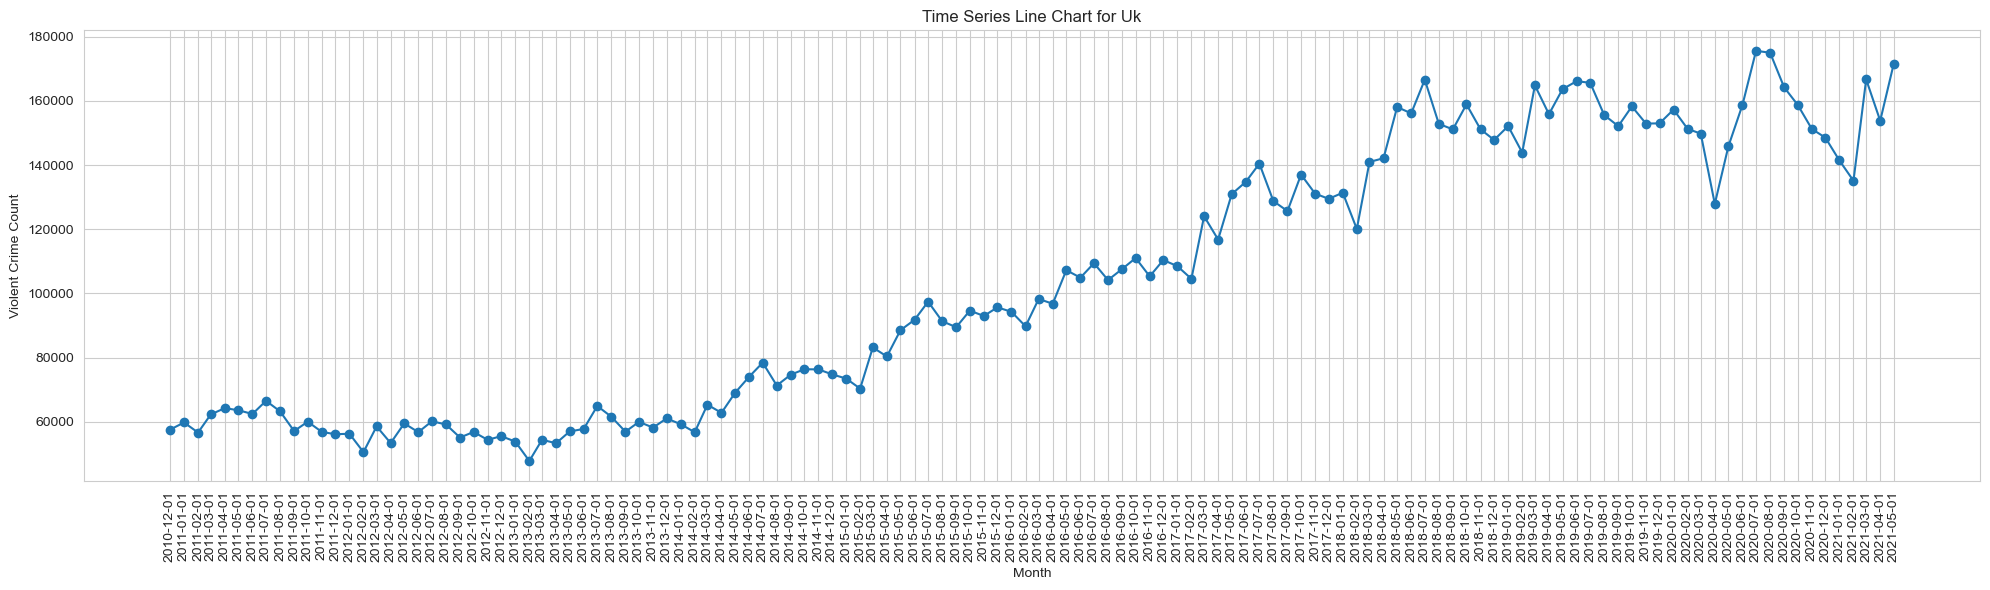

In [12]:
chart_type = 'Time Series Line Chart'
plot_crime_data(uk_crime_count_pd_df, chart_type, 'uk')

The image is a time series chart of monthly UK crime counts. Key points include:

1. **Trend**: There is rise of crime counts in Uk from 2014 and peaking in the late 2017 to early 2018.
2. **Seasonality**: Seasonal patterns are present with peaks in every year.
3. **Consistency**: There is presence of monthly patterns each year. This could be due to several factors like weather, holidays , etc.
4. **Volatility**: There is also month-to-month swings and a significant drop at the start of 2020, possibly due to COVID-19 lockdowns.

Histogram in pictorial form provides the most common graphical summary of a random sample. Also is estimate of the underlying probability density function (pdf). The data points are tabulated into a list of disjoint bins (Scott, 2009).

Visualizing UK crime data in Histogram


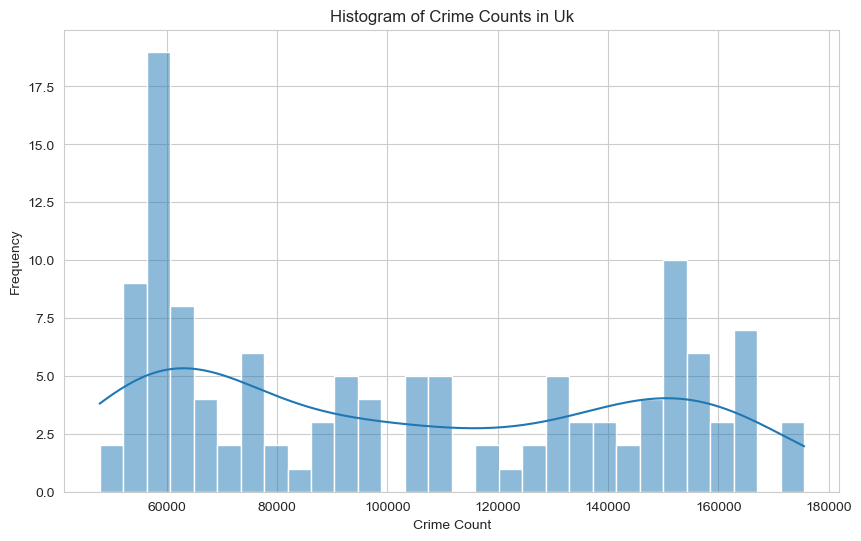

In [13]:
chart_type = 'Histogram'
plot_crime_data(uk_crime_count_pd_df, chart_type, 'uk')

The image is a histogram with a KDE line detailing UK crime counts:

1. **Shape**: The distribution observed in the histogram is not normal. It is bimodal and show two high crime count levels.
2. **Frequency**: Most the crime frequencies are lower, means crime counts are mostly lower.
3. **KDE**: The smoothed curve tells us that the distribution is bimodal.
4. **Variability**: The data spans a wide range of values, showing significant variability.
5. **Outliers**: Sparse high-value bars suggest occasional months or years with exceptionally high crime rates.

Box plot or box-and-whisker plot is basically a graphical representation of statistical data. It is generally  based on the minimum, first quartile, median, third quartile and maximum. It is very effective for showing the distribution and variability of a sample (Krzywinski and Altman, 2014).

Visualizing UK crime data in Box Plot


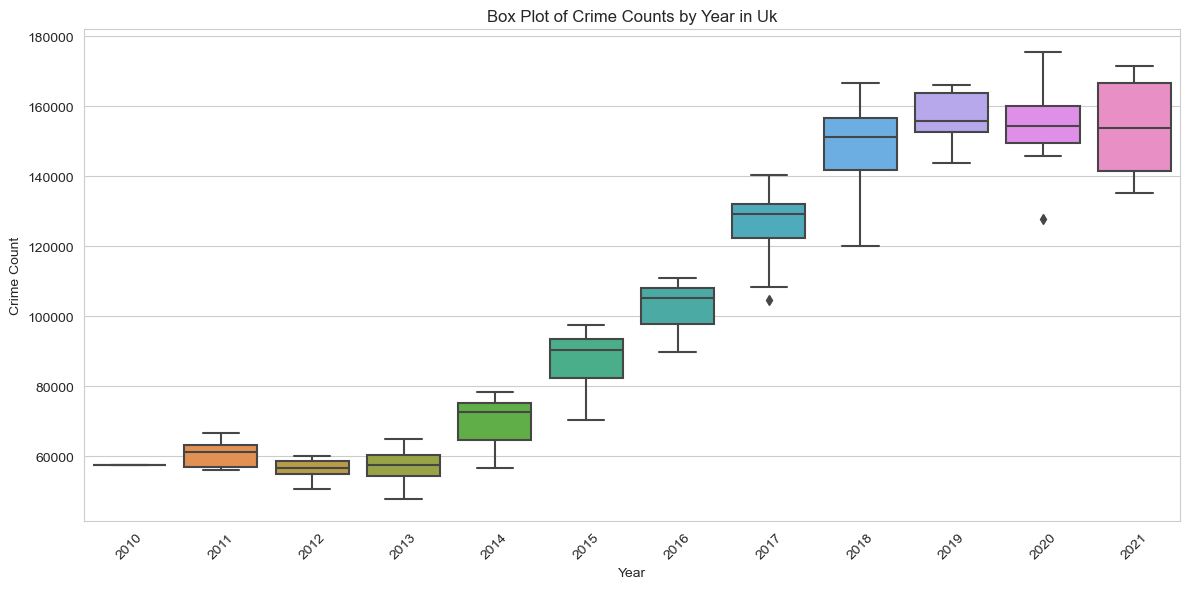

In [14]:
chart_type = 'Box Plot'
plot_crime_data(uk_crime_count_pd_df, chart_type, 'uk')

The above is a box plot graph of UK crime counts by year from 2010 to 2021:

1. **Trend**: A rise in median crime counts over the years, especially post-2014.
2. It can be observed that there is rise in median crime count in the given years, mainly after 2014.
3. **Outliers**: Lowest count Outlier can be seen in 2016 and highest count outlier can be seen in 2018.
4. **Yearly Consistency**: Narrow IQR in 2013 and in 2016 it indicates consistent counts. Wider IQR in 2018 and greater variability in 2021.
5. **Extremes**: Higest median count is in 2021 and the lowest is in 2013.
6. **Distribution**: More symmetrical distribution up to 2015 and skewness can be observed from 2016 onwards.
7. **Year-to-Year Changes**: Significant changes observed between some years, like 2014-2015 and 2017-2018.

Heatmap graph visualizes multi dimensional data into two dimensional format. It generally displays table with numbers and different colors. It is very usefully for finding patterns , correlations and trend in complex data (Gehlenborg and Wong, 2012).

Visualizing UK crime data in Heatmap


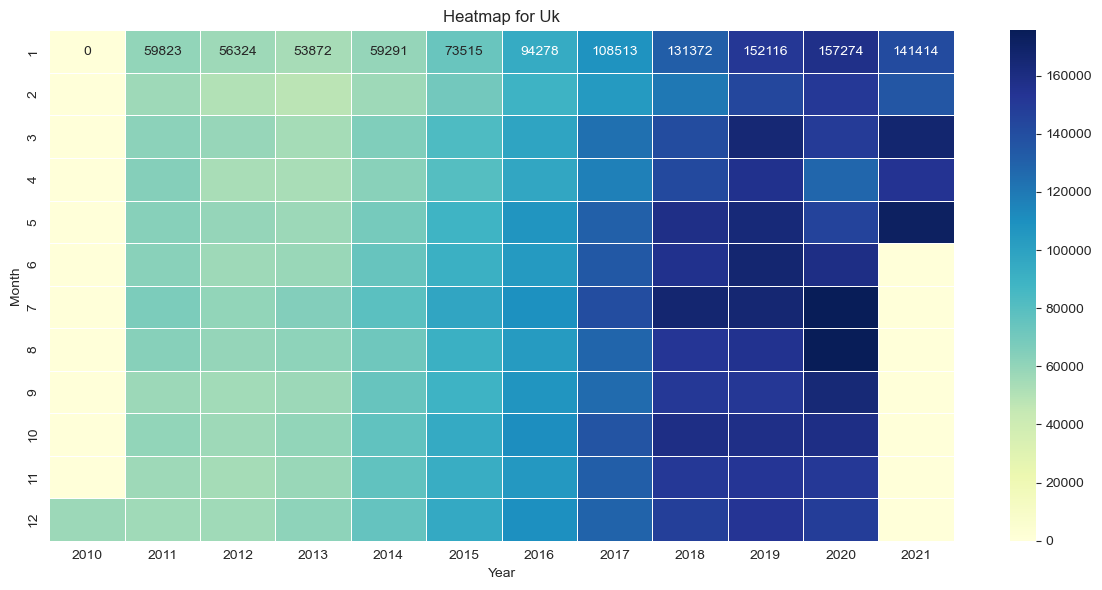

In [15]:
chart_type = 'Heatmap'
plot_crime_data(uk_crime_count_pd_df, chart_type, 'uk')

The image is a heatmap of UK monthly crime data from 2010 to 2021:

1. **Trend**: The darkening of the shades from 2010 to 2021 indicates that there is overall increase in crime.
2. **Seasonality**: Seasonal crime spikes are present as we can see that there is consistent darker shades in specific months.
3. **Recent Years**: From 2017 to 2021 the crime rates can be said to be higher because of the darker tones.
4. **Monthly Trends**: Some month show continuously higher crime rates every year
5. **Anomalies**: Some months, like January, consistently show lower crime rates.
6. **Latest Data**: Varied crime rates in 2021, with a peak in the final month.


### prediction with random forest reggression method(machine learning model) ###

Random forest is a model that users randomization for creating huge number decision trees. Again the output generated by these trees are aggregated into one outp by using averaging for regression tasks and voting for classification tasks (Rigatti, 2017).

Analyzing and predicting UK crime data
Mean Squared Error on Test Set: 7696553.168554173
Mean Absolute Error on Test Set: 2156.542083333335
R^2 Score on Test Set: 0.8195444700165871
Mean Absolute Percentage Error on Test Set: 1.36%


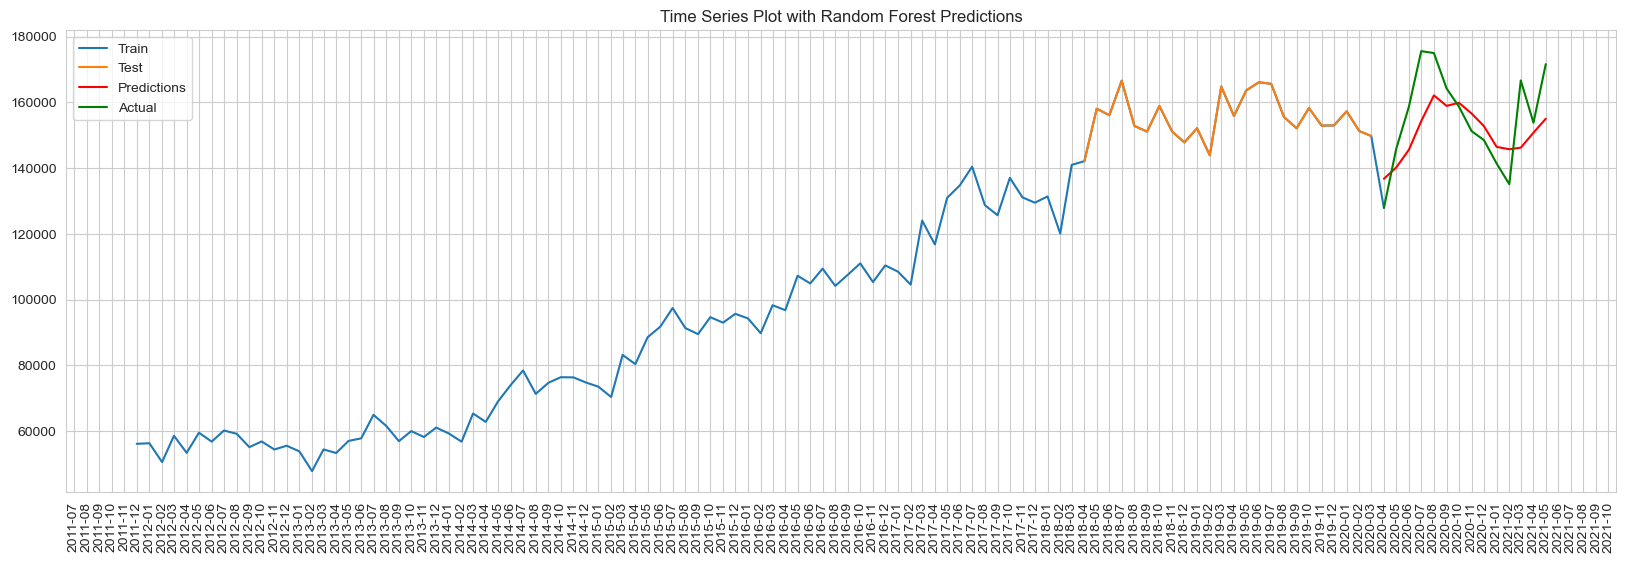

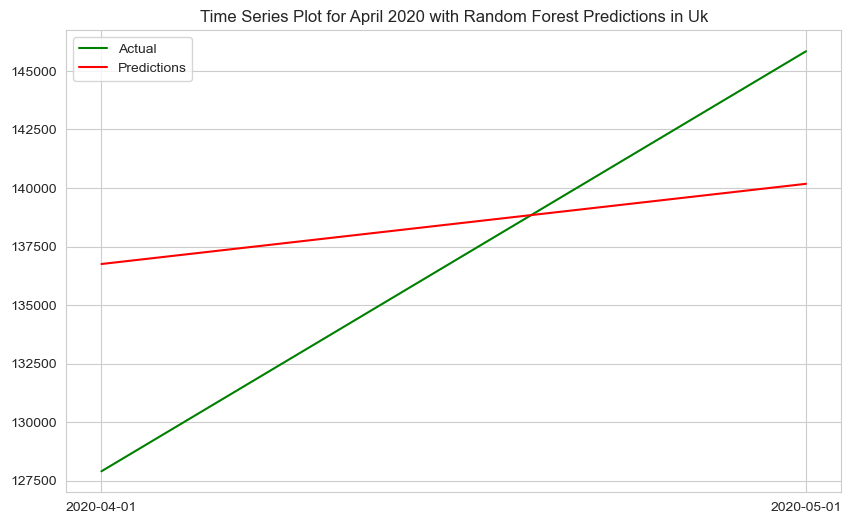

In [16]:
def prepare_and_predict_crime_data(df: pd.DataFrame, region: str, month: str):
    """
    Prepare crime data, train a Random Forest model, make predictions, and plot the results.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the crime data.
    region (str): The region for which the data is being analyzed.
    month (str): The month number for which we will be pridicting ('4' for April or '7' for July).
    """
    # Print statements based on region
    if region.lower() == 'uk':
        print("Analyzing and predicting UK crime data")
    elif region.lower() == 'leicester':
        print("Analyzing and predicting Leicester crime data")
    
    crime_predict_df = copy.copy(df)
    crime_predict_df['Month'] = pd.to_datetime(crime_predict_df['Month'])
    
    # Creating lag features
    for i in range(1, 13):
        crime_predict_df[f'lag_{i}'] = crime_predict_df['count'].shift(i)
    
    crime_predict_df.dropna(inplace=True)
    
    # Splitting the data
    train = crime_predict_df[crime_predict_df['Month'] <= f'2020-0{month}-01']
    test = crime_predict_df[(crime_predict_df['Month'] >= f'2018-0{month}-01') & (crime_predict_df['Month'] <= f'2020-0{str(int(month)-1)}-01')]
    predict_set = crime_predict_df[(crime_predict_df['Month'] > f'2020-0{str(int(month)-1)}-01') & (crime_predict_df['Month'] <= f'2021-0{str(int(month)+1)}-01')]
    
    # Defining features and labels
    X_train, y_train = train.drop(['count', 'Month'], axis=1), train['count']
    X_test, y_test = test.drop(['count', 'Month'], axis=1), test['count']
    X_predict = predict_set.drop(['count', 'Month'], axis=1)
    
    # Training the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Making predictions
    predictions = rf_model.predict(X_predict)
    
    # Evaluating the model
    mse = mean_squared_error(y_test, rf_model.predict(X_test))
    mae = mean_absolute_error(y_test, rf_model.predict(X_test))
    r2 = r2_score(y_test, rf_model.predict(X_test))
    mape = mean_absolute_percentage_error(y_test, rf_model.predict(X_test))
    
    print(f'Mean Squared Error on Test Set: {mse}')
    print(f'Mean Absolute Error on Test Set: {mae}')
    print(f'R^2 Score on Test Set: {r2}')
    print(f'Mean Absolute Percentage Error on Test Set: {mape * 100:.2f}%')
    
    # Plotting full time series with predictions
    plt.figure(figsize=(20, 6))
    plt.plot(train['Month'], train['count'], label='Train')
    plt.plot(test['Month'], test['count'], label='Test')
    plt.plot(predict_set['Month'], predictions, label='Predictions', color='red')
    plt.plot(predict_set['Month'], predict_set['count'], label='Actual', color='green')
    # Format the x-axis to show both year and month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('Time Series Plot with Random Forest Predictions')
    plt.show()
    
    # Filtering and plotting for a specific period
    filtered_predict_set = predict_set[(predict_set['Month'] >= f'2020-0{month}-01') & (predict_set['Month'] <= f'2020-0{str(int(month)+1)}-01')]
    filtered_predictions = predictions[(predict_set['Month'] >= f'2020-0{month}-01') & (predict_set['Month'] <= f'2020-0{str(int(month)+1)}-01')]
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_predict_set['Month'], filtered_predict_set['count'], label='Actual', color='green')
    plt.plot(filtered_predict_set['Month'], filtered_predictions, label='Predictions', color='red')
    # Format the x-axis to show both year and month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.legend()
    if month == "4":
        month_char = "April 2020"
    elif month == "7":
        month_char = "July 2020"
    plt.title(f'Time Series Plot for {month_char} with Random Forest Predictions in {region.capitalize()}')
    plt.show()
prepare_and_predict_crime_data(uk_crime_count_pd_df, 'uk','4')


### Time Series Plot with Random Forest Predictions for UK

1. **Model Performance**: It appears there is deviation in between the predicted values and the actual values. Specially in the end of the time series there we can see the model overestimates the crime counts in comparison to the actual data.

2. **Overall Trend**: The actual data seems to have a sharper increase compared to the predicted data. Although both the predicted and actual data shows upward trend in crime.

### Time Series Plot for April 2020 with Random Forest Predictions

1. **Short-Term Analysis**: This plot mainly focus on the short-term prediction for the month of April 2020.

2. **Actual vs. Predicted**: There is discrepancy in between the model prediction (red line) vs the actual data (green line). The actual data is increasing but the prediction done by model is flat.

3. **Contextual Note**: In the month of April 2020 there was lockdown in UK , the fist wave of COVID-19. It could be possible reason for the unexpected increase in crime counts and the model could not predict it.

The graphs insights shows that the Random Forest model is able to capture the general trend of the crime counts, but it struggles with change in the pattern which is not present in the historical data it was trained with.This highlights the importance of including external factors and possibly recalibrating the model to account for unprecedented events like the COVID-19 pandemic.

***Visualization and ml prediction for lecister region***

Visualizing Leicester crime dataTime Series Line Chart


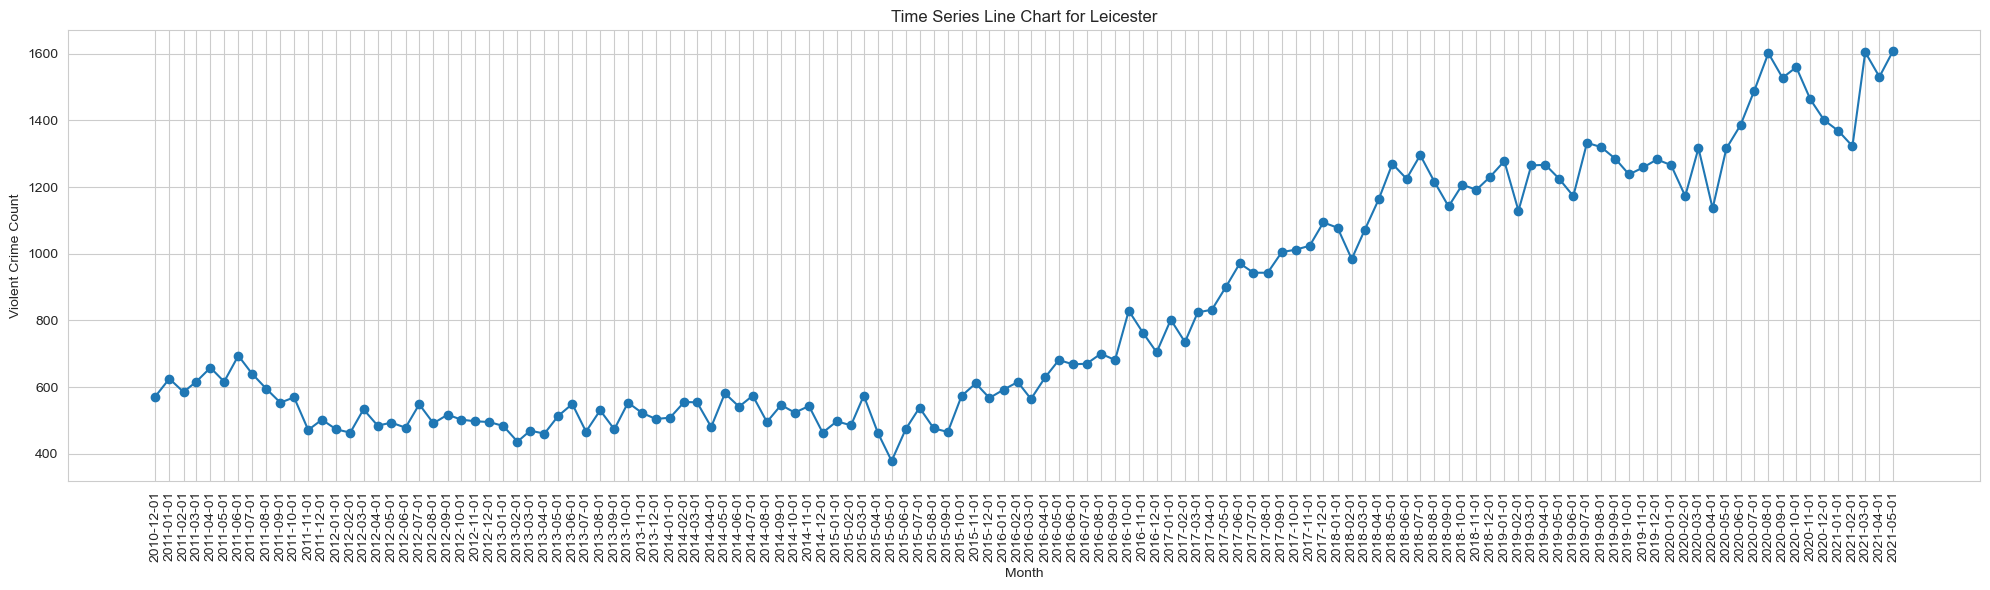

In [17]:
chart_type = 'Time Series Line Chart'
plot_crime_data(lstr_crime_count_pd_df, chart_type, 'leicester')

- **Trend**: Rising violent crime over the years is observed from the graph.
- **Fluctuations**: There are regular peaks and troughs which indicate seasonal or cyclical patterns.
- **Latest Variability**: Sharp fluctuations can be observed in 2020 to 2021 range, due to COVID-19 effects.

Visualizing Leicester crime dataHistogram


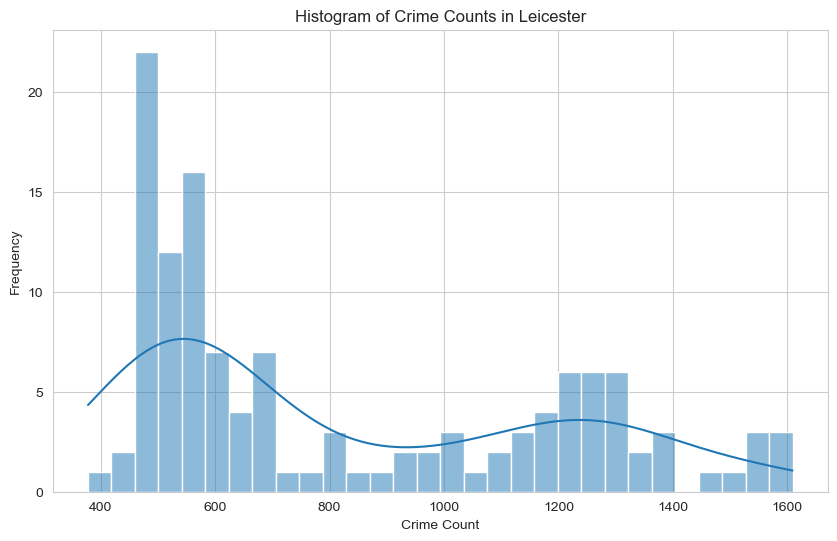

In [18]:
chart_type = 'Histogram'
plot_crime_data(lstr_crime_count_pd_df, chart_type, 'leicester')

1. **Shape**: The graph shows Bimodal distribution with two peaks.
2. **Common Ranges**: The most common frequency crime count peaks is around 500 to 600 range followed by 1100 to 1200.
3. **KDE Confirmation**: The KDE line shows that there are two prevalent crime count ranges.
4. **Tail**: A longer tail toward higher crime counts shows less frequent high-crime periods.

Visualizing Leicester crime dataBox Plot


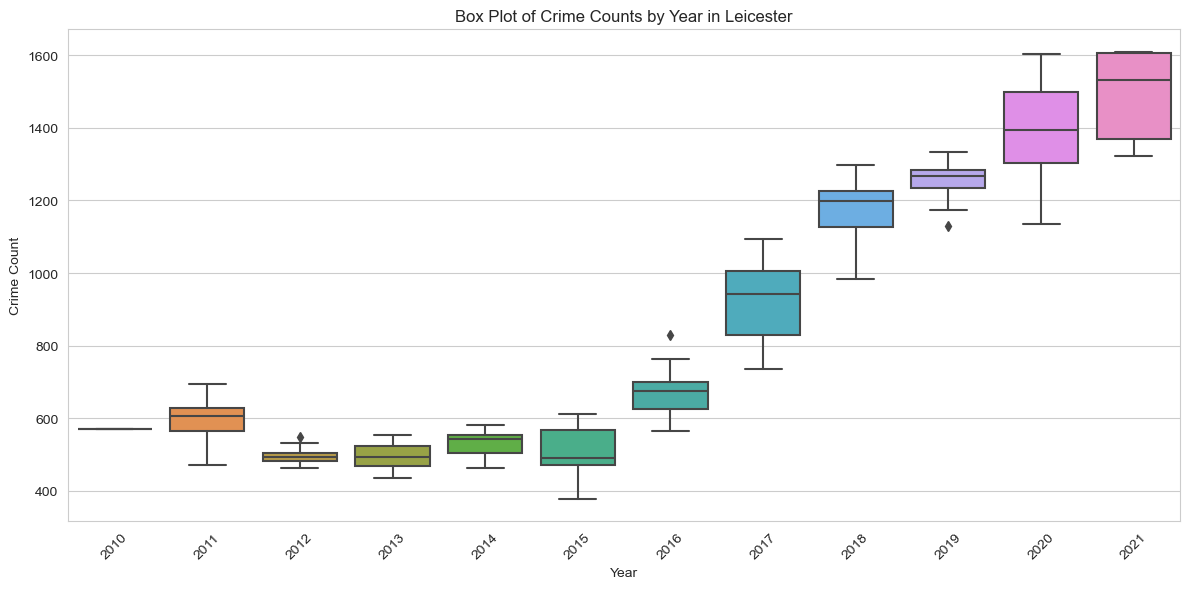

In [19]:
chart_type = 'Box Plot'
plot_crime_data(lstr_crime_count_pd_df, chart_type, 'leicester')


1. **General Trend**: We can see rise in median crime counts, particularly since 2014.
2. **Variability**: Crime counts vary more from 2014 onwards .
3. **Outliers**: Crime counts are unusual in 2012, 2018, and 2020.
4. **Consistency**: More consistent annual crime counts over 2010 to 2013.


Visualizing Leicester crime dataHeatmap


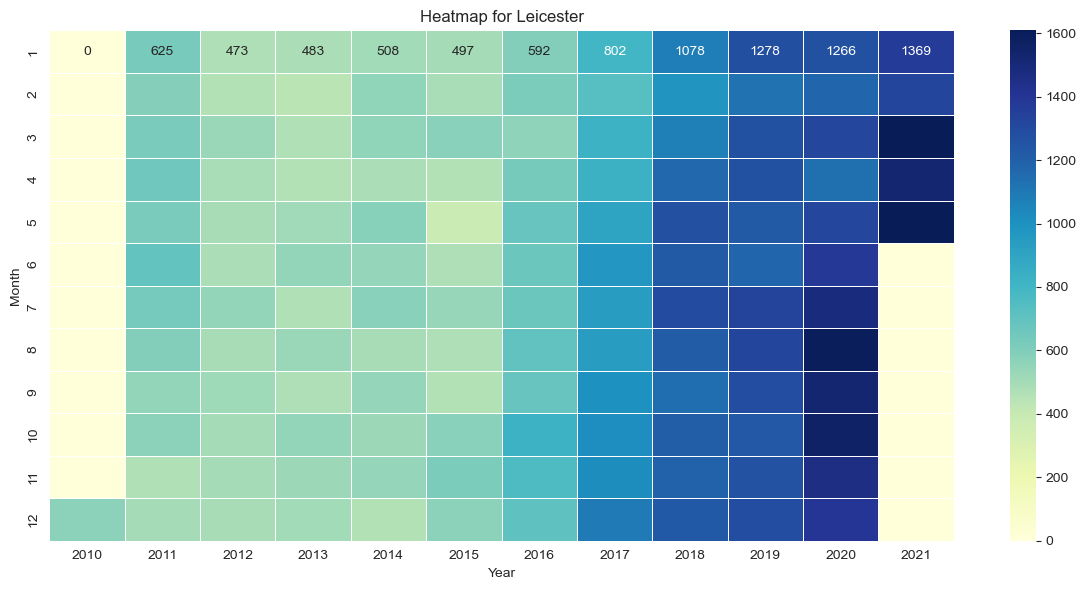

In [20]:
chart_type = 'Heatmap'
plot_crime_data(lstr_crime_count_pd_df, chart_type, 'leicester')

1. **Annual Trend**: The overall crime rate has generally increased over the past few years.
2. **Monthly Patterns**: Crime trends tend to be higher in specific months during the later years..
3. **Comparative Year Analysis**: Crime increases consistently between 2018 and 2021 in comparison to previous years.
4. **Lowest and Highest Counts**: Crime statistics: No crimes were reported in January 2010; 1369 crimes were reported in December 2021.

Analyzing and predicting Leicester crime data
Mean Squared Error on Test Set: 750.9881166666663
Mean Absolute Error on Test Set: 21.642499999999995
R^2 Score on Test Set: 0.8261366113835988
Mean Absolute Percentage Error on Test Set: 1.76%


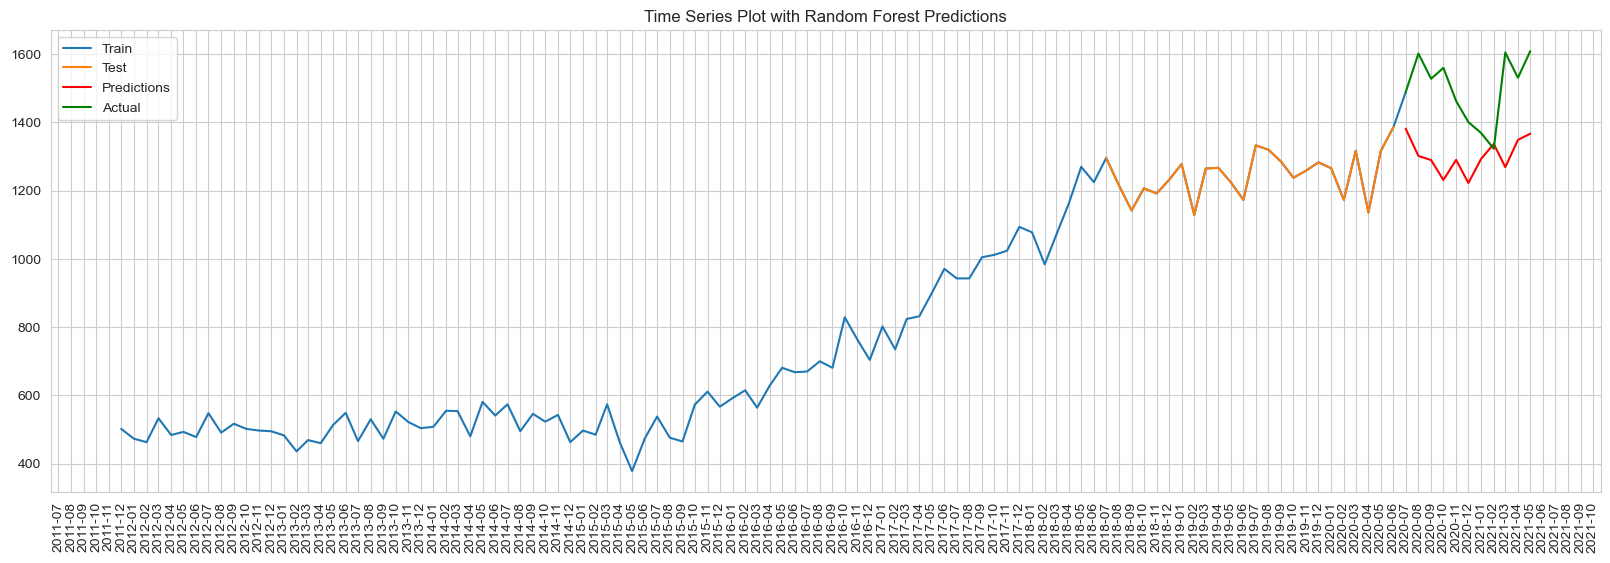

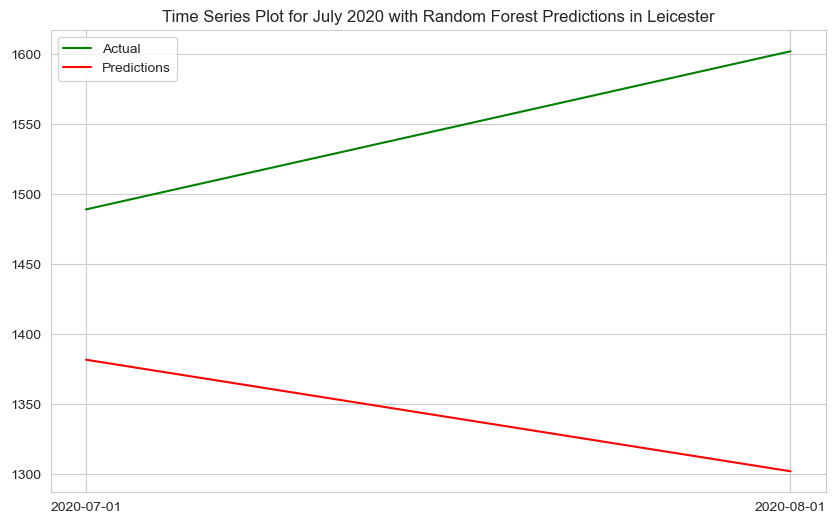

In [21]:
prepare_and_predict_crime_data(lstr_crime_count_pd_df, 'Leicester','7')

The Second Graph shows a time series plot for July 2020 with Random Forest predictions for crime in Leicester:

- **Prediction vs Actual**: The predictions of the model crime count differs from the actual data. The predicted data is decreasing but the actual data is increasing.
### Key Points:
- **External Factors**: The COVID-19 pandemic could have influenced the crime rates, affecting the model's predictions.

# 5) Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures   _markdown_, _code_,  _markdown_, 20 Marks

Stationarity is required for time series analysis. The mean, variance, and autocorrelation of a time series are stationary over time. Statistical estimates are valid only if the series remains constant. Future values are predicted based on past observations. The differences between two time series can remove systematic components that violate stationarity in real-life time series (Jebb et. al., 2015).

 > Is the Original Data stationary?
Test statistic = -0.305
P-value = 0.925
Critical values:
	1%: -3.489589552580676 - The data is not stationary with 99% confidence
	5%: -2.887477210140433 - The data is not stationary with 95% confidence
	10%: -2.580604145195395 - The data is not stationary with 90% confidence
 > Is the First Differenced Data stationary?
Test statistic = -2.350
P-value = 0.156
Critical values:
	1%: -3.490683082754047 - The data is not stationary with 99% confidence
	5%: -2.8879516565798817 - The data is not stationary with 95% confidence
	10%: -2.5808574442009578 - The data is not stationary with 90% confidence
 > Is the Second Differenced Data stationary?
Test statistic = -6.681
P-value = 0.000
Critical values:
	1%: -3.4912451337340342 - The data is  stationary with 99% confidence
	5%: -2.8881954545454547 - The data is  stationary with 95% confidence
	10%: -2.5809876033057852 - The data is  stationary with 90% confidence


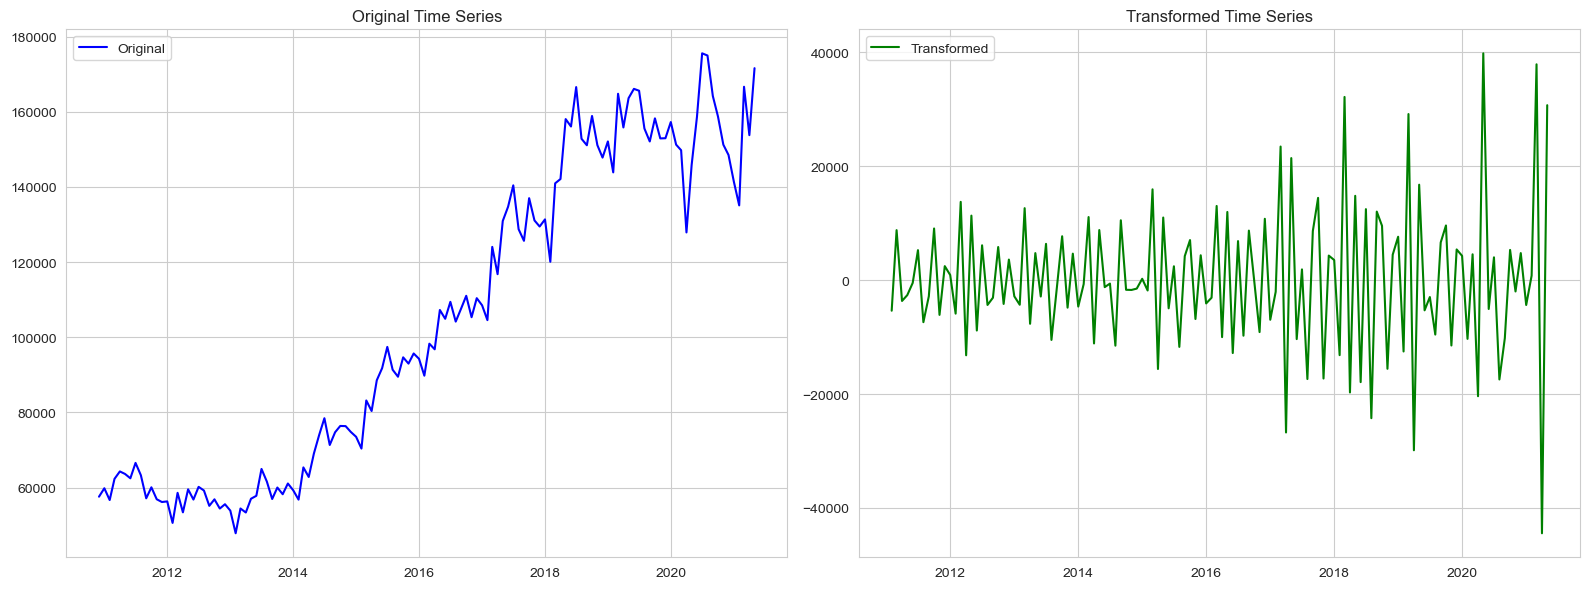

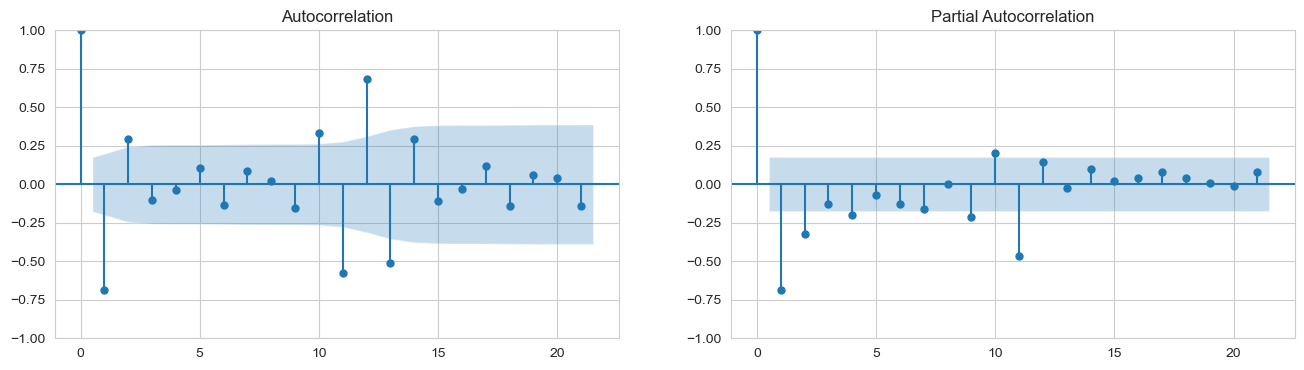

The data might be over-differenced.
 > Is the Detrended Data stationary?
Test statistic = -1.504
P-value = 0.531
Critical values:
	1%: -3.4968181663902103 - The data is not stationary with 99% confidence
	5%: -2.8906107514600103 - The data is not stationary with 95% confidence
	10%: -2.5822770483285953 - The data is not stationary with 90% confidence
 > Is the Log Differenced Data stationary?
Test statistic = -2.334
P-value = 0.161
Critical values:
	1%: -3.489589552580676 - The data is not stationary with 99% confidence
	5%: -2.887477210140433 - The data is not stationary with 95% confidence
	10%: -2.580604145195395 - The data is not stationary with 90% confidence
 > Is the Seasonally Adjusted Data stationary?
Test statistic = -8.462
P-value = 0.000
Critical values:
	1%: -3.4912451337340342 - The data is  stationary with 99% confidence
	5%: -2.8881954545454547 - The data is  stationary with 95% confidence
	10%: -2.5809876033057852 - The data is  stationary with 90% confidence


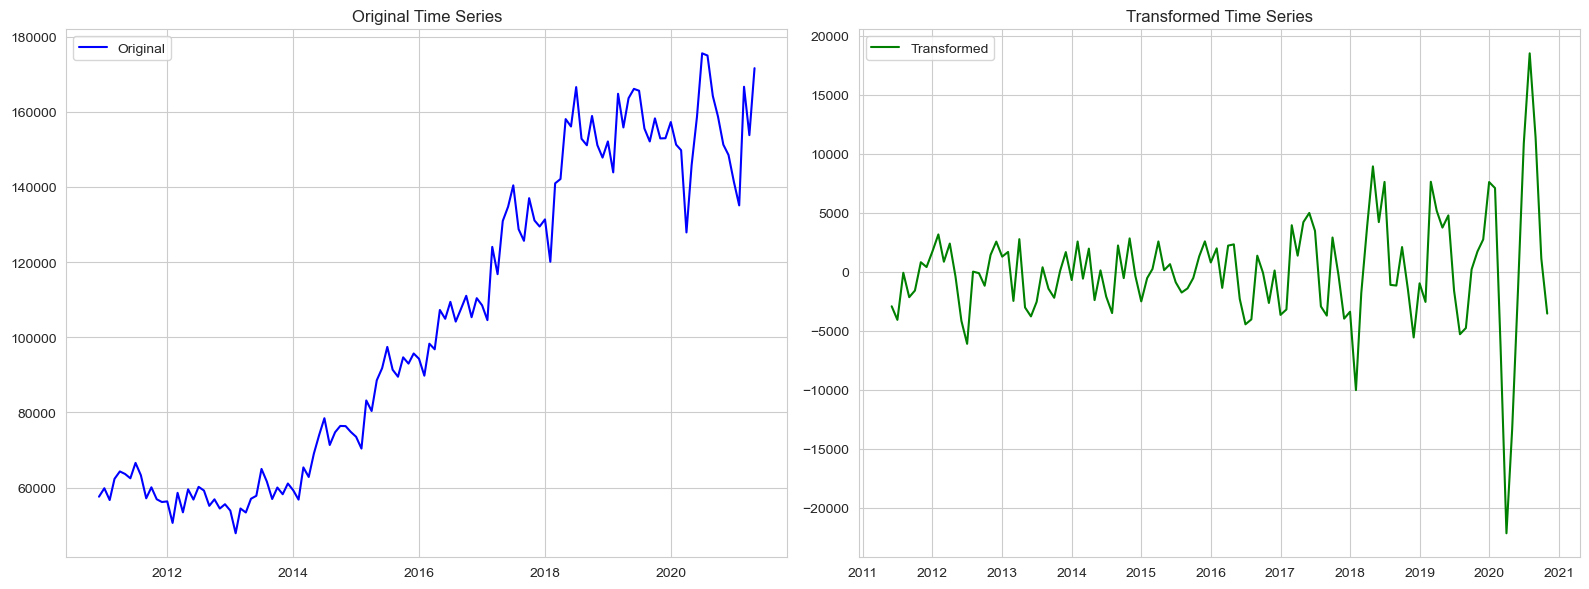

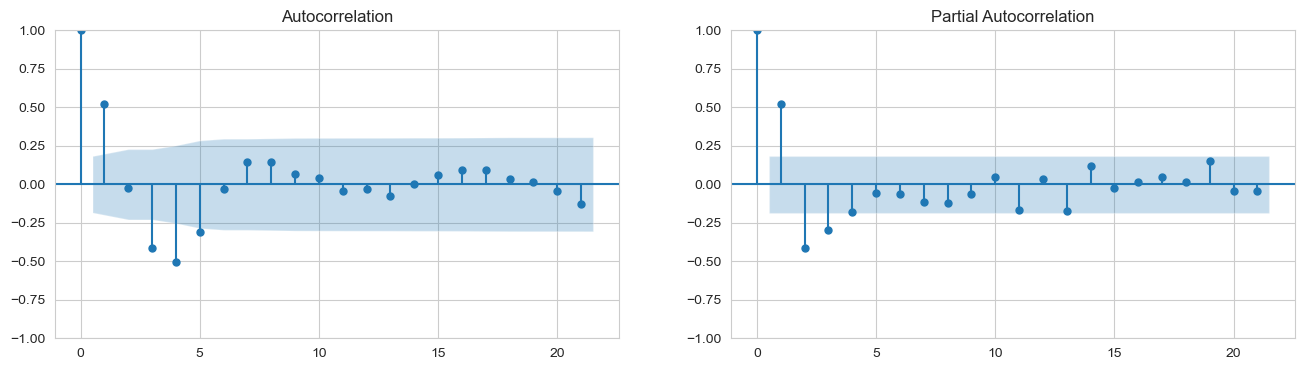

The data does not appear to be over-differenced.


In [22]:
class StationarityChecker:
    def __init__(self, timeseries: pd.Series):
        self.original_timeseries = timeseries
        self.transformed_timeseries = None
        self.is_stationary = False

    def ADF_test(self, timeseries, dataDesc):
        print(f' > Is the {dataDesc} stationary?')
        dftest = adfuller(timeseries.dropna(), autolag='AIC')
        print(f'Test statistic = {dftest[0]:.3f}')
        print(f'P-value = {dftest[1]:.3f}')
        print('Critical values:')
        for k, v in dftest[4].items():
            print(f'\t{k}: {v} - The data is {"not" if v < dftest[0] else ""} stationary with {100-int(k[:-1])}% confidence')
        self.is_stationary = dftest[1] <= 0.05

    def test_stationarity(self):
        self.transformed_timeseries = self.original_timeseries.copy()

        # Check original data for stationarity
        self.ADF_test(self.transformed_timeseries, "Original Data")
        if self.is_stationary:
            # Plot the original and transformed data
            stationarity_checker.plot_original_and_transformed()
            
            # Check for over-differencing if the data is stationary
            stationarity_checker_return = stationarity_checker.check_over_differencing()
            if stationarity_checker_return == 0:
                return self.transformed_timeseries

        # Try different transformations

        # First Differencing
        self.transformed_timeseries = self.original_timeseries.diff().dropna()
        self.ADF_test(self.transformed_timeseries, "First Differenced Data")
        if self.is_stationary:
            # Plot the original and transformed data
            stationarity_checker.plot_original_and_transformed()

            # Check for over-differencing if the data is stationary
            stationarity_checker_return = stationarity_checker.check_over_differencing()
            if stationarity_checker_return == 0:
                return self.transformed_timeseries

        # Second Differencing
        self.transformed_timeseries = self.original_timeseries.diff().diff().dropna()
        self.ADF_test(self.transformed_timeseries, "Second Differenced Data")
        if self.is_stationary:
            # Plot the original and transformed data
            stationarity_checker.plot_original_and_transformed()

            # Check for over-differencing if the data is stationary
            stationarity_checker_return = stationarity_checker.check_over_differencing()
            if stationarity_checker_return == 0:
                return self.transformed_timeseries

        # Detrending
        self.transformed_timeseries = (self.original_timeseries - self.original_timeseries.rolling(window=12).mean()) / self.original_timeseries.rolling(window=12).std()
        self.transformed_timeseries.dropna(inplace=True)
        self.ADF_test(self.transformed_timeseries, "Detrended Data")
        if self.is_stationary:
            # Plot the original and transformed data
            stationarity_checker.plot_original_and_transformed()

            # Check for over-differencing if the data is stationary
            stationarity_checker_return = stationarity_checker.check_over_differencing()
            if stationarity_checker_return == 0:
                return self.transformed_timeseries

        # Log Differencing
        log_transformed = np.log(self.original_timeseries)
        self.transformed_timeseries = log_transformed - log_transformed.shift()
        self.transformed_timeseries.dropna(inplace=True)
        self.ADF_test(self.transformed_timeseries, "Log Differenced Data")
        if self.is_stationary:
            # Plot the original and transformed data
            stationarity_checker.plot_original_and_transformed()

            # Check for over-differencing if the data is stationary
            stationarity_checker_return = stationarity_checker.check_over_differencing()
            if stationarity_checker_return == 0:
                return self.transformed_timeseries

        # Seasonal Decomposition
        decomposition = seasonal_decompose(self.original_timeseries, model='additive', period=12)
        self.transformed_timeseries = decomposition.resid
        self.transformed_timeseries.dropna(inplace=True)
        self.ADF_test(self.transformed_timeseries, "Seasonally Adjusted Data")
        if self.is_stationary:
            # Plot the original and transformed data
            stationarity_checker.plot_original_and_transformed()

            # Check for over-differencing if the data is stationary
            stationarity_checker_return = stationarity_checker.check_over_differencing()
            if stationarity_checker_return == 0:
                return self.transformed_timeseries

        return None

    def plot_original_and_transformed(self):
        plt.figure(figsize=(16, 6))

        # Plot Original Time Series
        plt.subplot(121)
        plt.plot(self.original_timeseries, color='blue', label='Original')
        plt.title('Original Time Series')
        plt.legend(loc='best')
    
        # Plot Transformed Time Series
        plt.subplot(122)
        if self.transformed_timeseries is not None:
            plt.plot(self.transformed_timeseries, color='green', label='Transformed')
            plt.title('Transformed Time Series')
        else:
            plt.title('No Stationary Transformation Applied')
        plt.legend(loc='best')
    
        plt.tight_layout()
        plt.show()


    def check_over_differencing(self):
        if self.is_stationary:
            # Plot ACF and PACF
            fig, axes = plt.subplots(1, 2, figsize=(16, 4))
            plot_acf(self.transformed_timeseries, ax=axes[0])
            plot_pacf(self.transformed_timeseries, ax=axes[1])
            plt.show()
    
            # Check for over-differencing
            acf_values = acf(self.transformed_timeseries, nlags=1)
            pacf_values = pacf(self.transformed_timeseries, nlags=1)
    
            if acf_values[1] < -0.5 or pacf_values[1] < -0.5:
                print("The data might be over-differenced.")
                return 1
            else:
                print("The data does not appear to be over-differenced.")
                return 0

timeseries_data = uk_crime_count_pd_df["count"]
stationarity_checker = StationarityChecker(timeseries_data)

# Check and get the stationary data if possible
uk_stationary_data = stationarity_checker.test_stationarity()

Analyzing time series data with ACF and PACF plots:

- **ACF Plot**: Positive correlation at lag 1, then drops off at higher lags, showing no significant correlation.
- **PACF Plot**: Significant at lag 1, with no significance at higher lags.

**Key Points**:

- **Data Behavior**: Data could be stationary but influenced by past values.

**Additional Observation**:

- **Stationarity Efforts**: Log diff, detrending, and differencing failed to make the data stationary until the second differencing and PACF indicates over-differencing.
- **Seasonal Decomposition**: Achieved stationarity.

These findings guide the construction of an ARIMA model for modeling and forecasting.

SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with Exogenous Factors) is an advanced form of the ARIMA model used in time series analysis. By incorporating ARIMA, it also accounts for seasonality and external factors in the data. Time series with seasonal patterns and external factors are particularly useful for this model. Similarly to ARIMA, SARIMAX specifies two orders for seasonal and non-seasonal parts (p, d, q) (Martinez, Silva and Fabbro, 2011).

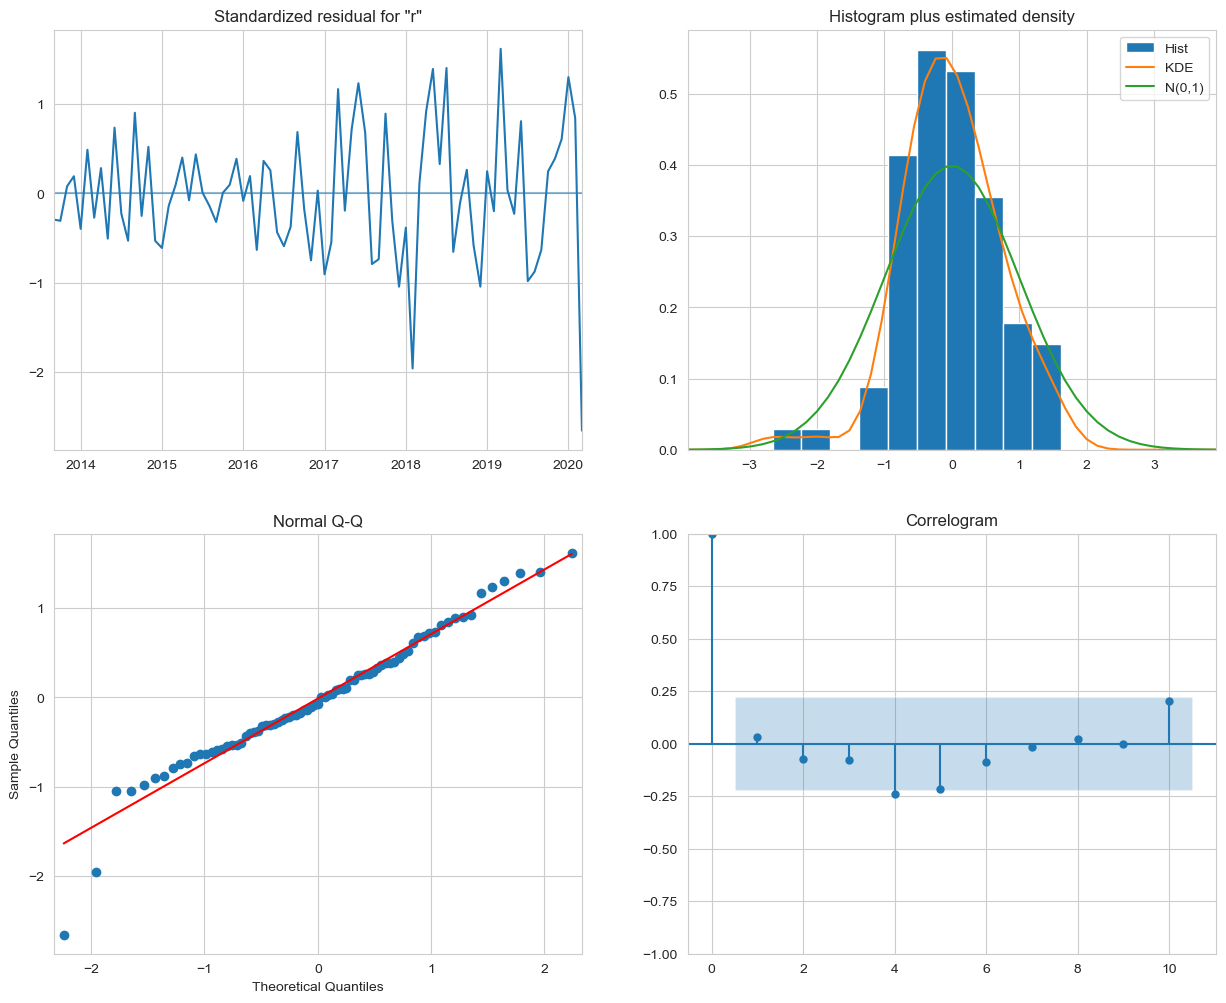

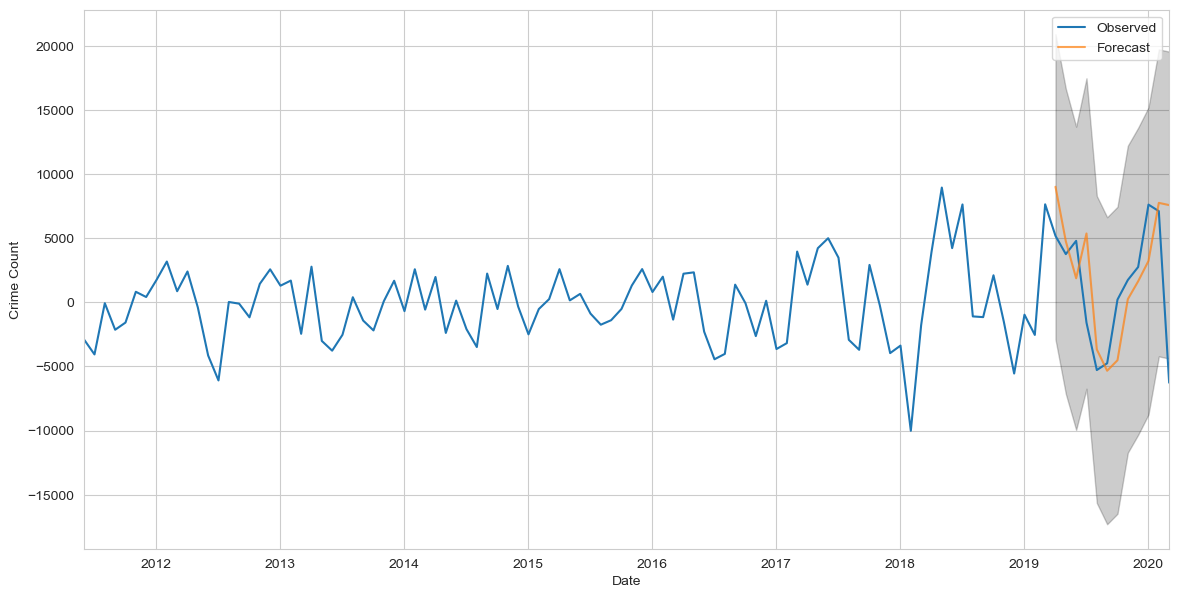

The pred_ci of our forecasts is              lower resid   upper resid
2019-04-01  -2882.922712  20902.833305
2019-05-01  -7131.712903  16652.214058
2019-06-01  -9943.375391  13694.918904
2019-07-01  -6733.358513  17466.867331
2019-08-01 -15643.684735   8296.095859
2019-09-01 -17299.342572   6633.800629
2019-10-01 -16483.270572   7449.673479
2019-11-01 -11724.492336  12208.444362
2019-12-01 -10325.490472  13607.445882
2020-01-01  -8739.553946  15193.382388
2020-02-01  -4212.110065  19720.826229
2020-03-01  -4385.213581  19547.721180
The Mean Squared Error of our forecasts is 26058091.476383906
The Root Mean Squared Error of our forecasts is 5104.712673244588


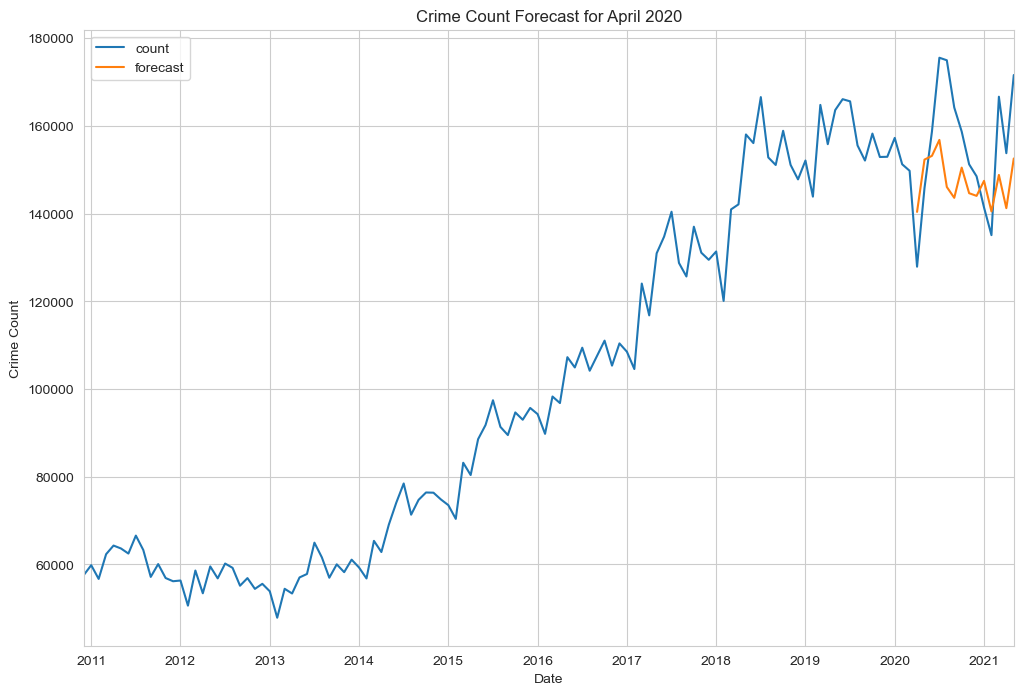

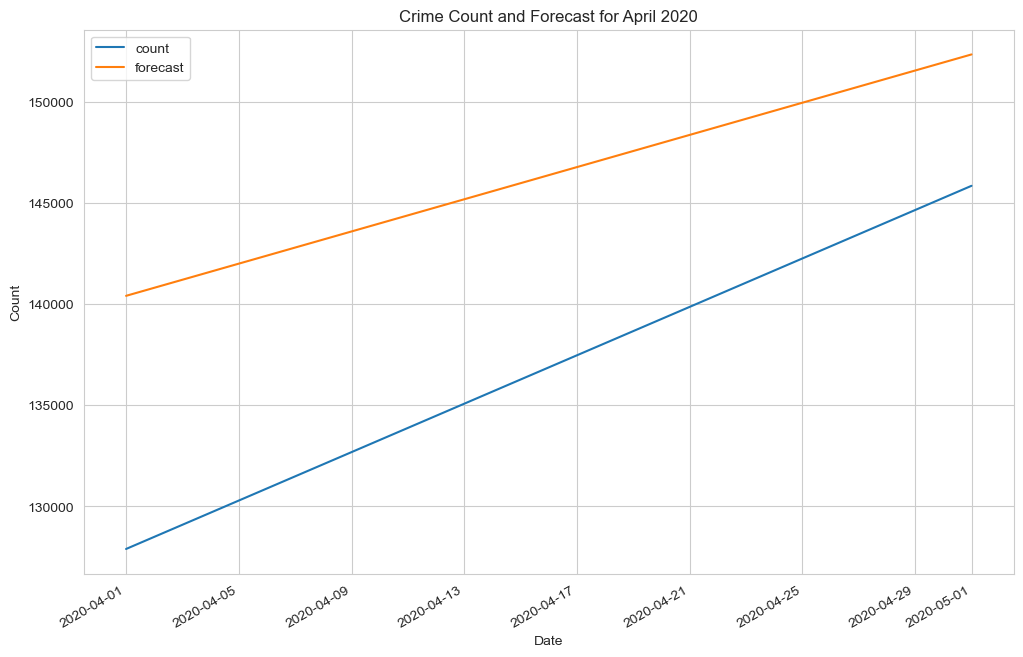

In [23]:
def run_sarimax_analysis(data, region, seasonal_period=12):
    """
    Performs SARIMAX analysis on the provided dataset for a specific region.

    Parameters:
    data (DataFrame): The dataset containing crime counts.
    region (str): The region to analyze ('uk' or 'leicester').
    seasonal_period (int): The period for seasonal differentiation.

    Returns:
    tuple: A tuple containing the model's results and the forecast data.
    """
    if region == "uk":
        train_end = '2020-03-01'
        test_start = '2019-04-01'
        test_end = '2020-03-01'
        sarimax_uk_crime_count_pd_df = uk_crime_count_pd_df.copy()
        pridiction_sdate = "2020-04-01"
        word_month = "April 2020"
    elif region == "leicester":
        train_end = '2020-06-01'
        test_start = '2019-07-01'
        test_end = '2020-06-01'
        sarimax_uk_crime_count_pd_df = lstr_crime_count_pd_df.copy()
        pridiction_sdate = "2020-07-01"
        word_month = "July 2020"
    # Split the data into training and test datasets
    y_to_train = data[:train_end]
    y_to_test = data[test_start:test_end]

    # Set Grid Search Parameters for SARIMAx
    warnings.filterwarnings("ignore")  # Ignore warning messages
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in pdq]

    # Find the best parameters
    lowest_aic = float("inf")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y_to_train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit(disp=False)

                if results.aic < lowest_aic:
                    lowest_aic = results.aic
                    lowest_aic_params = param
                    lowest_aic_seasonal_params = param_seasonal

            except Exception as ex:
                continue
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    
    # Build the model with the best parameters
    mod = sm.tsa.statespace.SARIMAX(sarimax_uk_crime_count_pd_df['count'],
                                    order=lowest_aic_params,
                                    seasonal_order=lowest_aic_seasonal_params,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit(disp=False)
    
    
    
    # Build the model with the best parameters
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=lowest_aic_params,
                                    seasonal_order=lowest_aic_seasonal_params,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results1 = mod.fit(disp=False)
    
    
    # Prediction
    pred = results1.get_prediction(start=pd.to_datetime(test_start), end=pd.to_datetime(test_end), dynamic=False)
    pred_ci = pred.conf_int()
    # Plot the forecast along with the confidence interval
    ax = y_to_train.plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime Count')
    plt.legend()
    plt.show()
    
    # Evaluate the model
    y_forecasted = pred.predicted_mean
    y_truth = y_to_test
    mse = mean_squared_error(y_truth, y_forecasted)
    rmse = sqrt(mse)
    print(f'The pred_ci of our forecasts is {pred_ci}')
    print(f'The Mean Squared Error of our forecasts is {mse}')
    print(f'The Root Mean Squared Error of our forecasts is {rmse}')
    
    sarimax_uk_crime_count_pd_df['forecast'] = results.predict(start=pd.to_datetime(pridiction_sdate),
                                                       dynamic=True)
    # Plottinng the actual counts and the forecast
    sarimax_uk_crime_count_pd_df[['count', 'forecast']].plot(figsize=(12, 8))
    plt.title(f'Crime Count Forecast for {word_month}')
    plt.xlabel('Date')
    plt.ylabel('Crime Count')


    # Filter the DataFrame to only include data from April 2020 to May 2020
    filtered_df = sarimax_uk_crime_count_pd_df[(sarimax_uk_crime_count_pd_df['Month'] >= pridiction_sdate) & (sarimax_uk_crime_count_pd_df['Month'] < f'2020-0{str(int(pridiction_sdate[6])+2)}-01')]
    
    # Plotting
    filtered_df[['count', 'forecast']].plot(figsize=(12, 8))
    plt.title(f'Crime Count and Forecast for {word_month}')
    plt.xlabel('Date')
    plt.ylabel('Count')
    
    # Optionally, return the results and forecast data
    return results, data

results, forecast_data = run_sarimax_analysis(uk_stationary_data, "uk")

Model diagnostics and crime count forecasts are shown below:

1. **Residuals**: Scattered randomly around zero which indicates good fit.
2. **Histogram & KDE**: Residual distribution is near-normal with a slight tail deviation.
3. **Q-Q Plot**: Near-normal distribution with outliers, close to the reference line.

Plotting time series:

- **Observed Data**: Relatively stable with periodic variations, lack of a long-term trend.
- **Forecast**: Shows an initial rise then a decline in crime counts in 2020.

Data and forecasts on crime:

- **Long-term Trend**: Rising crime rates until 2019, overestimating crime counts in early 2020.
- **Short-term Trend**: Forecasts for April 2020 miss actual variability, suggesting model limitations.

The model makes good historical predictions, but there are discrepancies in short-term predictions, especially for early 2020 due to unforeseen events like COVID-19. Including new data and updating models improve forecast accuracy.

In [24]:
uk_stationary_data

Month
2011-06-01    -2910.541319
2011-07-01    -4061.141319
2011-08-01      -68.003819
2011-09-01    -2138.562153
2011-10-01    -1576.928819
                  ...     
2020-07-01    10894.067014
2020-08-01    18527.662847
2020-09-01    11375.562847
2020-10-01     1141.071181
2020-11-01    -3529.441319
Name: resid, Length: 114, dtype: float64

**For leicester region**

 > Is the Original Data stationary?
Test statistic = 0.622
P-value = 0.988
Critical values:
	1%: -3.484219653271961 - The data is not stationary with 99% confidence
	5%: -2.885145235641637 - The data is not stationary with 95% confidence
	10%: -2.579359138917794 - The data is not stationary with 90% confidence
 > Is the First Differenced Data stationary?
Test statistic = -16.079
P-value = 0.000
Critical values:
	1%: -3.484219653271961 - The data is  stationary with 99% confidence
	5%: -2.885145235641637 - The data is  stationary with 95% confidence
	10%: -2.579359138917794 - The data is  stationary with 90% confidence


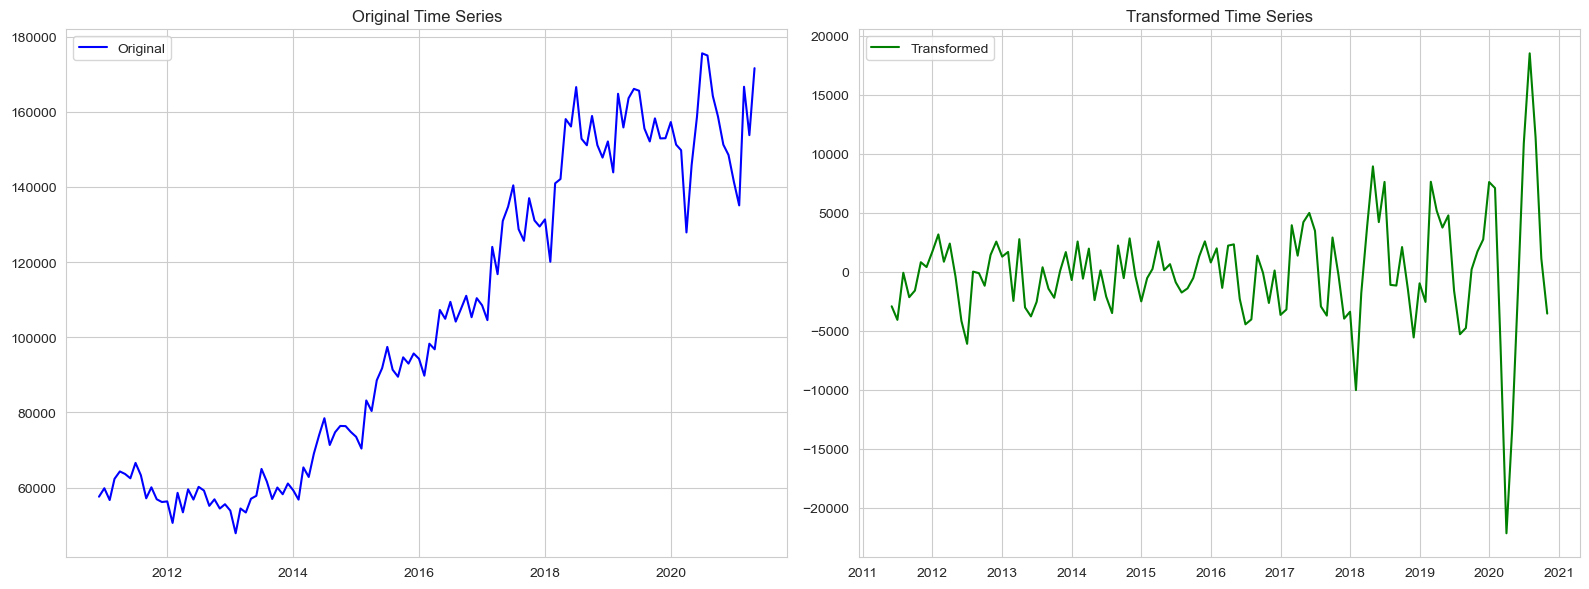

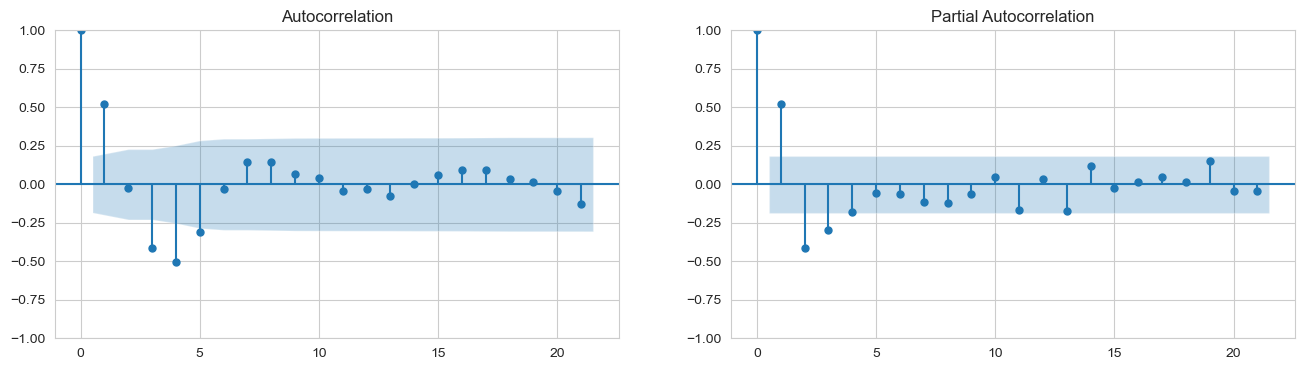

The data does not appear to be over-differenced.


In [25]:
lstr_timeseries_data = lstr_crime_count_pd_df["count"]
lstr_stationarity_checker = StationarityChecker(lstr_timeseries_data)

# Check and get the stationary data if possible
lstr_stationary_data = lstr_stationarity_checker.test_stationarity()


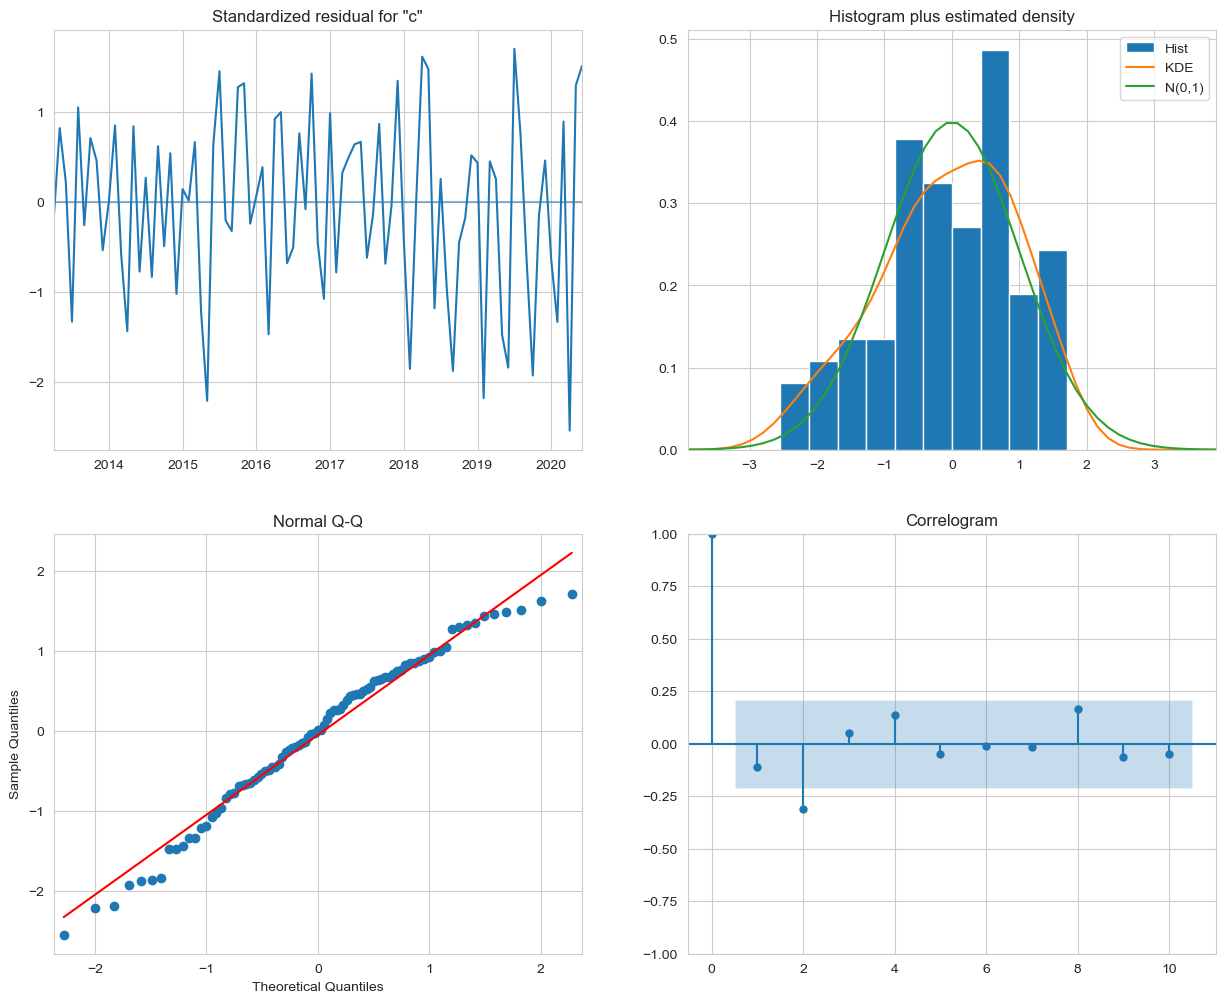

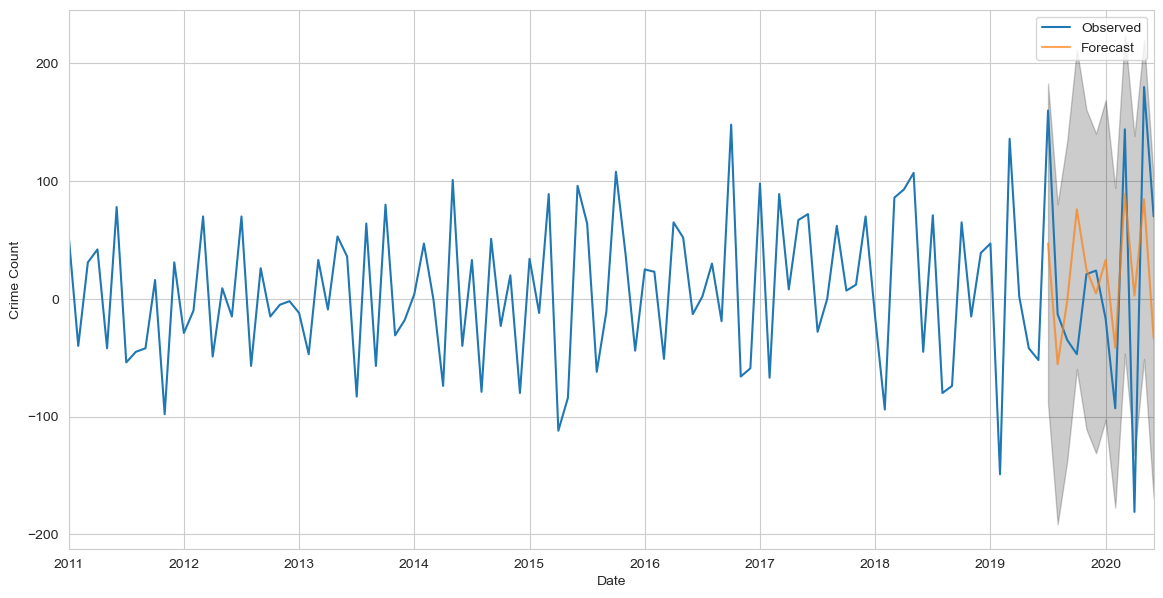

The pred_ci of our forecasts is             lower count  upper count
2019-07-01   -88.978393   182.856158
2019-08-01  -191.467064    80.298701
2019-09-01  -137.498605   134.201384
2019-10-01   -59.737518   211.899509
2019-11-01  -110.867769   160.708960
2019-12-01  -131.139714   140.378832
2020-01-01  -102.778470   168.685299
2020-02-01  -177.242637    94.139251
2020-03-01   -46.508438   224.811772
2020-04-01  -132.911808   138.349758
2020-05-01   -51.044454   220.160783
2020-06-01  -169.096262   102.054893
The Mean Squared Error of our forecasts is 7748.116444096578
The Root Mean Squared Error of our forecasts is 88.02338577955621


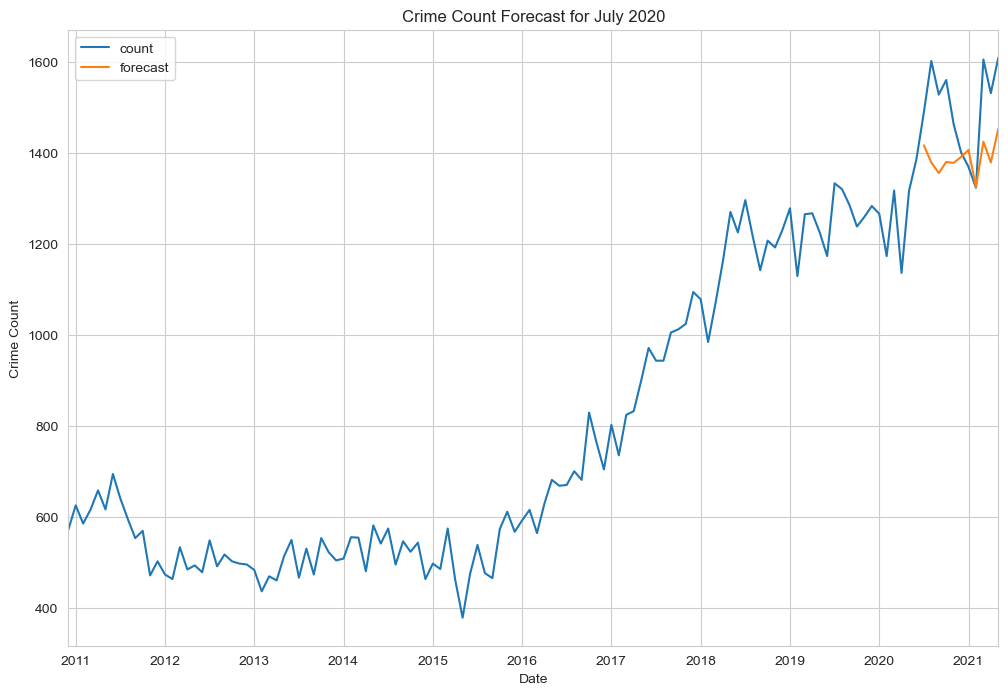

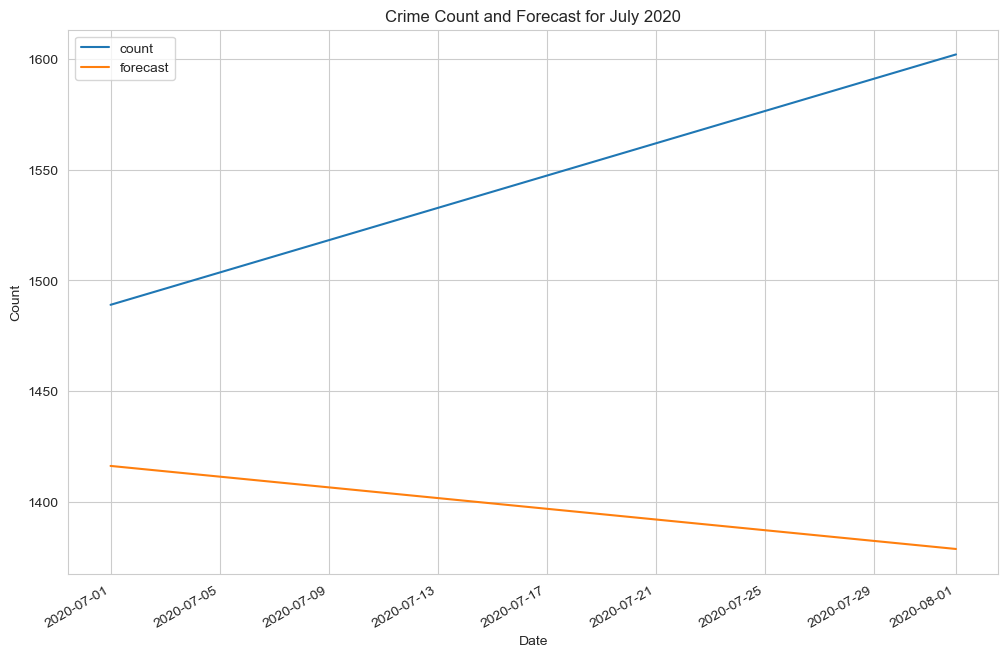

In [26]:
lstr_results, lstr_forecast_data = run_sarimax_analysis(lstr_stationary_data, "leicester")

Diagnostic plots are shown in the image:

1. **Residuals**: No patterns around zero, which indicates an appropriate fit.
2. **Histogram with KDE**: Residues are slightly abnormal.
3. **Q-Q Plot**: Outliers suggest normality with mostly straight lines.
4. **Correlogram**: Residues have no autocorrelation.

The time series plot shows:

- **Observed Data**: Seasonal effects are suggested by variable data without a clear trend.
- **Forecast**: An inital increase followed by a decline, with a wide confidence interval.


Leicester, July 2020:

- **Actual vs. Forecast**: Actual crime increases, while forecast decreases, indicating short-term predictions are inaccurate.

While the model captures long-term trends, it misses short-term fluctuations crucial for accurate forecasting.

# 6) Detailed Analysis and consideration of the appropriateness of the solution for the initial problem  _markdown_, 10 Marks

#### Random Forest Model
- **Advantages**: 
  - Ability to capture complex relationships.
  - Effectively handles large datasets.
  - Classes and regressions are versatile.
- **Disadvantages**: 
  - Incorrect tuning can cause overfitting.
  - Model interpretation is complex.
  - A lack of linear relationships outside of the training data.
- **Limitations**:
  - Anomalies or abrupt performance changes like COVID-19.
  - Increases computational costs by requiring many trees for stability.
  - Ineffectively captures sudden changes in trends or external influences.

#### SARIMAX Model
- **Advantages**: 
  - Enhances forecasting by accommodating seasonality and external factors.
  - Good for trending and seasonal data.
  - External influences, seasonality, and trend parameters in the model.
- **Disadvantages**: 
  - Tuning parameters and selecting models is complex.
  - Understands underlying data patterns.
  - Intense computational demands.
- **Limitations**:
  - Relies on time series stationarity assumptions.
  - Unable to handle sudden, non-systematic changes such as pandemics.
  - When external factors are not understood or quantified, accurate prediction can be challenging.

# 7) Evaluation and Conclusion  _markdown_, 10 Marks


#### Random Forest Model
- **Performance Metrics**:
  - Mean Squared Error (MSE) on Test Set: 7696553.168554173
  - Mean Absolute Error (MAE) on Test Set: 2156.542083333335
  - R^2 Score on Test Set: 0.8195444700165871
  - Mean Absolute Percentage Error (MAPE) on Test Set: 1.36%
- **Conclusion**:
  - Crime trends can be predicted using Random Forest.
  - The COVID-19 pandemic, however, has shown its limitations when faced with abrupt changes.
  - For the insurance company, while useful for understanding broad trends, the model may not be reliable for short-term predictions or under unusual circumstances.

#### SARIMAX Model
- **Performance Metrics**:
  - UK Crime Data: 
    - Mean Squared Error: 26058091.476383906
    - Root Mean Squared Error: 5104.712673244588
  - Leicester Crime Data:
    - Mean Squared Error: 7748.116444096578
    - Root Mean Squared Error: 88.02338577955621
- **Conclusion**:
  - SARIMAX provides a more nuanced understanding of crime data by accounting for seasonality and external influences.
  - While the higher MSE values suggest that forecasting crime rates accurately is difficult, particularly for UK data, they do indicate some limitations.
  - For the insurance company, SARIMAX can be a valuable tool for long-term planning and understanding seasonal trends, but caution should be exercised in relying solely on this model for precise forecasting, especially during unpredictable events like the pandemic.

To conclude, both models provide valuable insight into crime trends, but their limitations highlight the importance of using them together and regularly updating them with the latest data and external factors in order to achieve more accurate predictions. In this manner, the insurance company will be able to make more informed decisions regarding risks and make better assessments.

# 8) References and Citation _markdown_, 10 Marks

Gehlenborg, N. and Wong, B. (2012). Heat maps. Nature Methods, 9(3), pp.213–213. doi:https://doi.org/10.1038/nmeth.1902.

Jebb AT, Tay L, Wang W and Huang Q (2015) Time series analysis for psychological research: examining and forecasting change. Front. Psychol. 6:727. doi: 10.3389/fpsyg.2015.00727.

Krzywinski, M., Altman, N. (2014). Visualizing samples with box plots. Nat Methods, 11, 119-120. https://doi.org/10.1038/nmeth.2813).

Martinez, E.Z., Silva, E.A.S. da and Fabbro, A.L.D. (2011). A SARIMA forecasting model to predict the number of cases of dengue in Campinas, State of São Paulo, Brazil. Revista da Sociedade Brasileira de Medicina Tropical, 44(4), pp.436–440. doi:https://doi.org/10.1590/s0037-86822011000400007.

Piquero, A.R., Jennings, W.G., Jemison, E., Kaukinen, C. and Knaul, F.M. (2021). Domestic violence during the COVID-19 pandemic - Evidence from a systematic review and meta-analysis. Journal of Criminal Justice, [online] 74(101806). doi:https://doi.org/10.1016/j.jcrimjus.2021.101806.

Rigatti, S.J. (2017). Random Forest. Journal of Insurance Medicine, 47(1), pp.31–39. doi:https://doi.org/10.17849/insm-47-01-31-39.1.

Scott, D.W. (2009). Histogram. WIREs Computational Statistics, 2(1), pp.44–48. doi:https://doi.org/10.1002/wics.59.

The Economist. (2020). Domestic violence has increased during coronavirus lockdowns. [online] Available at: https://www.economist.com/graphic-detail/2020/04/22/domestic-violence-has-increased-during-coronavirus-lockdowns?utm_medium=cpc.adword.pd&utm_source=google&ppccampaignID=18156330227&ppcadID=&utm_campaign=a.22brand_pmax&utm_content=conversion.direct-response.anonymous&gad_source=1&gclsrc=ds [Accessed 18 Jan. 2024].

Velicer, W. F., & Fava, J. L.  (2003).  Time Series Analysis. In J. Schinka & W. F. Velicer (Eds.), Research Methods in Psychology(581-606). Volume 2,  Handbook of Psychology (I. B. Weiner, Editor-in-Chief.).  New York: John Wiley & Sons.



In [27]:
spark.stop()